In [4]:
!unzip /content/drive/MyDrive/Owen/grddc_whole_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: grddc_train/India/annotations/xmls/India_005125.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_005125.xml  
  inflating: grddc_train/India/annotations/xmls/India_003554.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_003554.xml  
  inflating: grddc_train/India/annotations/xmls/India_002892.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_002892.xml  
  inflating: grddc_train/India/annotations/xmls/India_008401.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_008401.xml  
  inflating: grddc_train/India/annotations/xmls/India_007732.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_007732.xml  
  inflating: grddc_train/India/annotations/xmls/India_008367.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_008367.xml  
  inflating: grddc_train/India/annotations/xmls/India_007054.xml  
  inflating:

In [12]:
!unzip /content/drive/MyDrive/Owen/grddc/GRDDC.zip

Streaming output truncated to the last 5000 lines.
  inflating: GRDDC/Czech_002300.jpg  
  inflating: GRDDC/Japan_012666.jpg  
  inflating: GRDDC/India_006474.jpg  
  inflating: GRDDC/India_009747.jpg  
  inflating: GRDDC/Japan_002475.jpg  
  inflating: GRDDC/India_008459.jpg  
  inflating: GRDDC/India_000005.jpg  
  inflating: GRDDC/Japan_000262.jpg  
  inflating: GRDDC/India_004263.jpg  
  inflating: GRDDC/Japan_009520.jpg  
  inflating: GRDDC/India_002612.jpg  
  inflating: GRDDC/Czech_001609.jpg  
  inflating: GRDDC/Japan_006613.jpg  
  inflating: GRDDC/Japan_009246.jpg  
  inflating: GRDDC/Japan_011409.jpg  
  inflating: GRDDC/India_002174.jpg  
  inflating: GRDDC/Japan_006175.jpg  
  inflating: GRDDC/India_004505.jpg  
  inflating: GRDDC/Japan_010717.jpg  
  inflating: GRDDC/Japan_008158.jpg  
  inflating: GRDDC/Czech_000271.jpg  
  inflating: GRDDC/India_000763.jpg  
  inflating: GRDDC/India_006312.jpg  
  inflating: GRDDC/India_009021.jpg  
  inflating: GRDDC/Japan_002313.jpg  

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD

import os
import joblib
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [13]:
labelled_data = pd.read_csv("/content/GRDDC/labelled_data.csv", header = 0)

In [14]:
labelled_data.columns = ['image','country','oldpath','box','cracking_binary']

In [15]:
labelled_data['new_path'] = "/content/grddc_train/" + labelled_data['country'].astype("str") + "/images/" + labelled_data['image'] + ".jpg"

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(labelled_data['new_path'].values, labelled_data['cracking_binary'].values, test_size=0.2, random_state=42)

In [ ]:
xtrain, xval, ytrain, yval= train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

In [ ]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xval, yval, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

In [ ]:
print(max(ytest), min(ytest))
print(max(ytrain), min(ytrain))

1 0
1 0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f65b49f1c90>,
 <matplotlib.image.AxesImage at 0x7f65b4d271d0>)

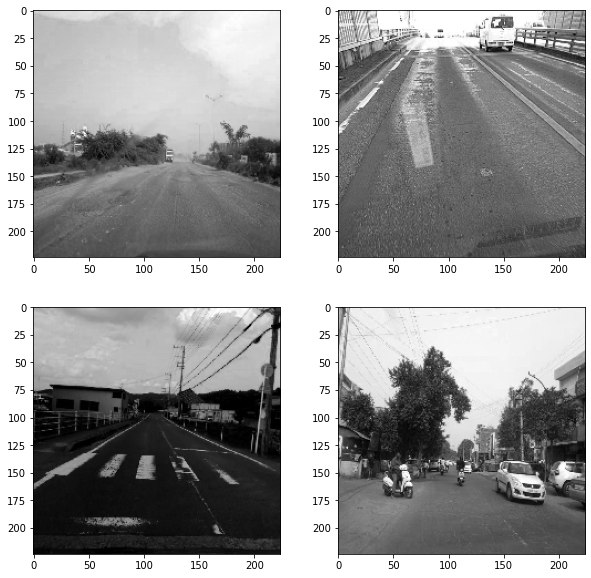

In [ ]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][2], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+2025][0][2], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+4050][0][2], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+8075][0][2], cmap='gray')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
def set_parameter_requires_grad(model, layers_untrained):
  layers_untrained = min(layers_untrained,61)
  for i,param in enumerate(model.parameters()):
    if i<layers_untrained:
      param.requires_grad = False

In [ ]:
# defining the model
model = models.resnet34(pretrained=True)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        print("TP",true_positives,"TN",true_negatives,"FP",false_positives,"FN",false_negatives)
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/international_baseline_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1 of 75
Training





  1%|▏         | 1/75 [00:02<02:56,  2.38s/it]


  3%|▎         | 2/75 [00:04<02:50,  2.34s/it]


  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]


  5%|▌         | 4/75 [00:08<02:40,  2.26s/it]


  7%|▋         | 5/75 [00:11<02:35,  2.23s/it]


  8%|▊         | 6/75 [00:13<02:32,  2.21s/it]


  9%|▉         | 7/75 [00:15<02:30,  2.21s/it]


 11%|█         | 8/75 [00:17<02:27,  2.20s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.18s/it]


 13%|█▎        | 10/75 [00:21<02:21,  2.18s/it]


 15%|█▍        | 11/75 [00:24<02:18,  2.16s/it]


 16%|█▌        | 12/75 [00:26<02:16,  2.17s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.17s/it]


 19%|█▊        | 14/75 [00:30<02:11,  2.16s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:37<02:06,  2.17s/it]


 24%|██▍       | 18/75 [00:39<02:03,  2.18s/it]


 25%|██▌       | 19/75 [00:41<02:02,  2.18s/it]


 27%|██▋       | 20/75 [00:43<02:00,  2.19s/it]


 28%|█

Train Loss: 0.5713, Train Acc: 71.22
Recall: 0.3142, Precision: 0.55, F1: 0.40
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.01s/it]


 25%|██▌       | 2/8 [00:03<00:11,  2.00s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.99s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.99s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.99s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.86s/it]


Val Loss: 0.6661, Val Acc: 71.32
Recall: 0.4303, Precision: 0.53, F1: 0.48





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2 of 75
Training





  1%|▏         | 1/75 [00:02<02:40,  2.17s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.16s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.17s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.16s/it]


 17%|█▋        | 13/75 [00:28<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:09,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:03,  2.16s/it]


 25%|██▌       | 19/75 [00:40<02:01,  2.17s/it]


 27%|██▋       | 20/75 [00:43<01:59,  2.16s/it]


 28%|█

Train Loss: 0.4908, Train Acc: 76.37
Recall: 0.4660, Precision: 0.66, F1: 0.55
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.06s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.06s/it]


 38%|███▊      | 3/8 [00:06<00:10,  2.05s/it]


 50%|█████     | 4/8 [00:08<00:08,  2.03s/it]


 62%|██████▎   | 5/8 [00:10<00:06,  2.03s/it]


 75%|███████▌  | 6/8 [00:12<00:04,  2.04s/it]


 88%|████████▊ | 7/8 [00:14<00:02,  2.03s/it]


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


9it [00:17,  1.90s/it]


Val Loss: 0.6382, Val Acc: 75.06
Recall: 0.2417, Precision: 0.78, F1: 0.37





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3 of 75
Training





  1%|▏         | 1/75 [00:02<02:41,  2.18s/it]


  3%|▎         | 2/75 [00:04<02:38,  2.17s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.19s/it]


  8%|▊         | 6/75 [00:13<02:31,  2.19s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.18s/it]


 11%|█         | 8/75 [00:17<02:24,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:16,  2.16s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.16s/it]


 19%|█▊        | 14/75 [00:30<02:11,  2.16s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:36<02:05,  2.17s/it]


 24%|██▍       | 18/75 [00:38<02:03,  2.17s/it]


 25%|██▌       | 19/75 [00:41<02:01,  2.16s/it]


 27%|██▋       | 20/75 [00:43<01:58,  2.16s/it]


 28%|█

Train Loss: 0.4035, Train Acc: 81.57
Recall: 0.6158, Precision: 0.74, F1: 0.67
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 0.6074, Val Acc: 74.82
Recall: 0.4794, Precision: 0.61, F1: 0.54





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.16s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:28,  2.18s/it]


 11%|█         | 8/75 [00:17<02:26,  2.18s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.17s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:16,  2.17s/it]


 17%|█▋        | 13/75 [00:28<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.15s/it]


 25%|██▌       | 19/75 [00:40<02:01,  2.16s/it]


 27%|██▋       | 20/75 [00:43<01:58,  2.16s/it]


 28%|█

Train Loss: 0.2878, Train Acc: 87.93
Recall: 0.7748, Precision: 0.82, F1: 0.80
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 0.8140, Val Acc: 68.35
Recall: 0.6798, Precision: 0.48, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5 of 75
Training





  1%|▏         | 1/75 [00:02<02:40,  2.17s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.16s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.17s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.12s/it]


 28%|█

Train Loss: 0.1845, Train Acc: 92.82
Recall: 0.8740, Precision: 0.89, F1: 0.88
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.94s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.95s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.0074, Val Acc: 70.01
Recall: 0.5481, Precision: 0.50, F1: 0.52





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:29,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:29,  2.13s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.17s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.17s/it]


 15%|█▍        | 11/75 [00:23<02:18,  2.17s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:08,  2.11s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:04,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:58,  2.15s/it]


 28%|█

Train Loss: 0.1186, Train Acc: 95.55
Recall: 0.9212, Precision: 0.93, F1: 0.93
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.00s/it]


 38%|███▊      | 3/8 [00:06<00:09,  2.00s/it]


 50%|█████     | 4/8 [00:07<00:07,  2.00s/it]


 62%|██████▎   | 5/8 [00:10<00:06,  2.01s/it]


 75%|███████▌  | 6/8 [00:12<00:04,  2.02s/it]


 88%|████████▊ | 7/8 [00:14<00:02,  2.02s/it]


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


9it [00:16,  1.89s/it]


Val Loss: 0.9298, Val Acc: 73.57
Recall: 0.5697, Precision: 0.56, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7 of 75
Training





  1%|▏         | 1/75 [00:02<02:41,  2.18s/it]


  3%|▎         | 2/75 [00:04<02:39,  2.19s/it]


  4%|▍         | 3/75 [00:06<02:36,  2.17s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:34,  2.21s/it]


  8%|▊         | 6/75 [00:13<02:31,  2.19s/it]


  9%|▉         | 7/75 [00:15<02:28,  2.18s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.12s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.12s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0787, Train Acc: 97.29
Recall: 0.9505, Precision: 0.96, F1: 0.96
Validating





 12%|█▎        | 1/8 [00:02<00:15,  2.14s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]


 38%|███▊      | 3/8 [00:06<00:10,  2.06s/it]


 50%|█████     | 4/8 [00:08<00:08,  2.02s/it]


 62%|██████▎   | 5/8 [00:10<00:06,  2.01s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  2.00s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  2.00s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.87s/it]


Val Loss: 1.1933, Val Acc: 73.93
Recall: 0.5835, Precision: 0.57, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.12s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:13<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.15s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0549, Train Acc: 98.16
Recall: 0.9673, Precision: 0.97, F1: 0.97
Validating





 12%|█▎        | 1/8 [00:01<00:13,  2.00s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.99s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


9it [00:16,  1.86s/it]


Val Loss: 1.2371, Val Acc: 73.57
Recall: 0.5619, Precision: 0.56, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9 of 75
Training





  1%|▏         | 1/75 [00:02<02:35,  2.10s/it]


  3%|▎         | 2/75 [00:04<02:34,  2.11s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:29,  2.14s/it]


  8%|▊         | 6/75 [00:12<02:27,  2.13s/it]


  9%|▉         | 7/75 [00:14<02:24,  2.12s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:19,  2.12s/it]


 13%|█▎        | 10/75 [00:21<02:17,  2.12s/it]


 15%|█▍        | 11/75 [00:23<02:14,  2.10s/it]


 16%|█▌        | 12/75 [00:25<02:12,  2.10s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.11s/it]


 19%|█▊        | 14/75 [00:29<02:08,  2.11s/it]


 20%|██        | 15/75 [00:31<02:06,  2.11s/it]


 21%|██▏       | 16/75 [00:33<02:04,  2.11s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.11s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.15s/it]


 28%|█

Train Loss: 0.0480, Train Acc: 98.35
Recall: 0.9709, Precision: 0.98, F1: 0.97
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.3231, Val Acc: 72.98
Recall: 0.6582, Precision: 0.54, F1: 0.60





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:34,  2.18s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:13<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.12s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.13s/it]


 20%|██        | 15/75 [00:32<02:08,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0368, Train Acc: 98.66
Recall: 0.9776, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.3723, Val Acc: 74.05
Recall: 0.5442, Precision: 0.57, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11 of 75
Training





  1%|▏         | 1/75 [00:02<02:40,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.12s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0366, Train Acc: 98.66
Recall: 0.9770, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:02<00:13,  2.00s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.99s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4017, Val Acc: 72.57
Recall: 0.4676, Precision: 0.55, F1: 0.51





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12 of 75
Training





  1%|▏         | 1/75 [00:02<02:40,  2.17s/it]


  3%|▎         | 2/75 [00:04<02:38,  2.17s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.12s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0369, Train Acc: 98.78
Recall: 0.9789, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.3238, Val Acc: 75.06
Recall: 0.4892, Precision: 0.61, F1: 0.54





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13 of 75
Training





  1%|▏         | 1/75 [00:02<02:41,  2.18s/it]


  3%|▎         | 2/75 [00:04<02:38,  2.17s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:32<02:06,  2.11s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:58,  2.15s/it]


 28%|█

Train Loss: 0.0454, Train Acc: 98.35
Recall: 0.9727, Precision: 0.97, F1: 0.97
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.08s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.05s/it]


 38%|███▊      | 3/8 [00:06<00:10,  2.02s/it]


 50%|█████     | 4/8 [00:07<00:08,  2.00s/it]


 62%|██████▎   | 5/8 [00:09<00:06,  2.00s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.99s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.86s/it]


Val Loss: 1.4408, Val Acc: 72.15
Recall: 0.5914, Precision: 0.54, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.13s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:19,  2.12s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.12s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.13s/it]


 20%|██        | 15/75 [00:32<02:08,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0287, Train Acc: 98.95
Recall: 0.9811, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.95s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.95s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.6213, Val Acc: 70.19
Recall: 0.6542, Precision: 0.51, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:33,  2.19s/it]


  8%|▊         | 6/75 [00:13<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.12s/it]


 13%|█▎        | 10/75 [00:21<02:17,  2.12s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0205, Train Acc: 99.31
Recall: 0.9890, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.83s/it]


Val Loss: 1.4573, Val Acc: 74.05
Recall: 0.6169, Precision: 0.56, F1: 0.59





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 16 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.12s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.11s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.11s/it]


 25%|██▌       | 19/75 [00:40<01:57,  2.11s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0199, Train Acc: 99.33
Recall: 0.9890, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.00s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.99s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.99s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.86s/it]


Val Loss: 1.5563, Val Acc: 72.92
Recall: 0.6464, Precision: 0.54, F1: 0.59





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17 of 75
Training





  1%|▏         | 1/75 [00:02<02:35,  2.10s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.10s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.11s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:55,  2.11s/it]


 28%|█

Train Loss: 0.0158, Train Acc: 99.52
Recall: 0.9922, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.95s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.95s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.83s/it]


Val Loss: 1.5419, Val Acc: 73.16
Recall: 0.6385, Precision: 0.55, F1: 0.59





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:33,  2.19s/it]


  8%|▊         | 6/75 [00:13<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.17s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:18,  2.17s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:28<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:08,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0138, Train Acc: 99.54
Recall: 0.9929, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4914, Val Acc: 73.93
Recall: 0.4637, Precision: 0.59, F1: 0.52





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19 of 75
Training





  1%|▏         | 1/75 [00:02<02:34,  2.08s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.10s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.14s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.16s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:07,  2.12s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.15s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0229, Train Acc: 99.20
Recall: 0.9871, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.8184, Val Acc: 73.99
Recall: 0.4735, Precision: 0.59, F1: 0.52





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:25,  2.17s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:04,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.12s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0391, Train Acc: 98.71
Recall: 0.9776, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.95s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5700, Val Acc: 71.44
Recall: 0.6267, Precision: 0.52, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 21 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:34,  2.12s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:29,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.12s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:31<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.15s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.15s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.13s/it]


 28%|█

Train Loss: 0.0248, Train Acc: 99.17
Recall: 0.9849, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4993, Val Acc: 73.99
Recall: 0.5128, Precision: 0.58, F1: 0.54





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 22 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.16s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:10,  2.11s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:31<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:04,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<01:59,  2.10s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.11s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0125, Train Acc: 99.63
Recall: 0.9942, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.02s/it]


 25%|██▌       | 2/8 [00:03<00:12,  2.00s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.99s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.99s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4107, Val Acc: 76.01
Recall: 0.5540, Precision: 0.61, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 23 of 75
Training





  1%|▏         | 1/75 [00:02<02:34,  2.09s/it]


  3%|▎         | 2/75 [00:04<02:32,  2.09s/it]


  4%|▍         | 3/75 [00:06<02:31,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:29,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:29,  2.13s/it]


  8%|▊         | 6/75 [00:12<02:27,  2.14s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.16s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.11s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.12s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.12s/it]


 28%|█

Train Loss: 0.0058, Train Acc: 99.85
Recall: 0.9972, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5765, Val Acc: 74.70
Recall: 0.6110, Precision: 0.58, F1: 0.59





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 24 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.11s/it]


 17%|█▋        | 13/75 [00:27<02:10,  2.11s/it]


 19%|█▊        | 14/75 [00:29<02:08,  2.11s/it]


 20%|██        | 15/75 [00:31<02:06,  2.11s/it]


 21%|██▏       | 16/75 [00:34<02:04,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0105, Train Acc: 99.62
Recall: 0.9942, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.99s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.99s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.99s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.7292, Val Acc: 74.52
Recall: 0.5599, Precision: 0.58, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 25 of 75
Training





  1%|▏         | 1/75 [00:02<02:40,  2.17s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.16s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:13<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.16s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.12s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.12s/it]


 28%|█

Train Loss: 0.0213, Train Acc: 99.27
Recall: 0.9866, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.95s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 2.0264, Val Acc: 74.64
Recall: 0.3674, Precision: 0.64, F1: 0.47





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 26 of 75
Training





  1%|▏         | 1/75 [00:02<02:35,  2.10s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.10s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.15s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<02:00,  2.15s/it]


 27%|██▋       | 20/75 [00:42<01:58,  2.15s/it]


 28%|█

Train Loss: 0.0406, Train Acc: 98.66
Recall: 0.9767, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4711, Val Acc: 73.93
Recall: 0.5285, Precision: 0.57, F1: 0.55





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 27 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.12s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:29<02:11,  2.15s/it]


 20%|██        | 15/75 [00:32<02:08,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0260, Train Acc: 99.14
Recall: 0.9856, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.4097, Val Acc: 74.82
Recall: 0.5029, Precision: 0.60, F1: 0.55





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 28 of 75
Training





  1%|▏         | 1/75 [00:02<02:42,  2.20s/it]


  3%|▎         | 2/75 [00:04<02:39,  2.19s/it]


  4%|▍         | 3/75 [00:06<02:37,  2.18s/it]


  5%|▌         | 4/75 [00:08<02:37,  2.22s/it]


  7%|▋         | 5/75 [00:11<02:35,  2.22s/it]


  8%|▊         | 6/75 [00:13<02:31,  2.20s/it]


  9%|▉         | 7/75 [00:15<02:29,  2.20s/it]


 11%|█         | 8/75 [00:17<02:25,  2.17s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:28<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.15s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:36<02:05,  2.16s/it]


 24%|██▍       | 18/75 [00:38<02:03,  2.16s/it]


 25%|██▌       | 19/75 [00:41<02:00,  2.15s/it]


 27%|██▋       | 20/75 [00:43<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0145, Train Acc: 99.54
Recall: 0.9927, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.5098, Val Acc: 74.35
Recall: 0.5521, Precision: 0.58, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 29 of 75
Training





  1%|▏         | 1/75 [00:02<02:42,  2.20s/it]


  3%|▎         | 2/75 [00:04<02:39,  2.18s/it]


  4%|▍         | 3/75 [00:06<02:35,  2.16s/it]


  5%|▌         | 4/75 [00:08<02:35,  2.19s/it]


  7%|▋         | 5/75 [00:10<02:33,  2.19s/it]


  8%|▊         | 6/75 [00:13<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:18,  2.16s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:28<02:13,  2.16s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.15s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:36<02:05,  2.16s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.16s/it]


 25%|██▌       | 19/75 [00:41<02:01,  2.17s/it]


 27%|██▋       | 20/75 [00:43<01:58,  2.16s/it]


 28%|█

Train Loss: 0.0053, Train Acc: 99.85
Recall: 0.9974, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5157, Val Acc: 75.65
Recall: 0.5403, Precision: 0.61, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 30 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:23,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:11,  2.12s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0036, Train Acc: 99.89
Recall: 0.9978, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.4952, Val Acc: 75.89
Recall: 0.5442, Precision: 0.61, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 31 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.11s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.11s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.11s/it]


 28%|█

Train Loss: 0.0026, Train Acc: 99.93
Recall: 0.9991, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5941, Val Acc: 76.01
Recall: 0.5108, Precision: 0.63, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 32 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:29,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.14s/it]


  8%|▊         | 6/75 [00:12<02:27,  2.14s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.15s/it]


 20%|██        | 15/75 [00:32<02:09,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.14s/it]


 25%|██▌       | 19/75 [00:40<02:00,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0041, Train Acc: 99.89
Recall: 0.9983, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.95s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.96s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.95s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.7189, Val Acc: 75.59
Recall: 0.5088, Precision: 0.62, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 33 of 75
Training





  1%|▏         | 1/75 [00:02<02:41,  2.18s/it]


  3%|▎         | 2/75 [00:04<02:38,  2.17s/it]


  4%|▍         | 3/75 [00:06<02:37,  2.19s/it]


  5%|▌         | 4/75 [00:08<02:34,  2.17s/it]


  7%|▋         | 5/75 [00:10<02:34,  2.20s/it]


  8%|▊         | 6/75 [00:13<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:28<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0080, Train Acc: 99.78
Recall: 0.9961, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.85s/it]


Val Loss: 2.0504, Val Acc: 74.94
Recall: 0.5305, Precision: 0.60, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 34 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.12s/it]


 17%|█▋        | 13/75 [00:27<02:10,  2.11s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0528, Train Acc: 98.09
Recall: 0.9677, Precision: 0.97, F1: 0.97
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.95s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5140, Val Acc: 74.29
Recall: 0.3556, Precision: 0.63, F1: 0.46





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 35 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:29<02:09,  2.12s/it]


 20%|██        | 15/75 [00:32<02:08,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.11s/it]


 25%|██▌       | 19/75 [00:40<01:57,  2.10s/it]


 27%|██▋       | 20/75 [00:42<01:55,  2.11s/it]


 28%|█

Train Loss: 0.0392, Train Acc: 98.57
Recall: 0.9755, Precision: 0.98, F1: 0.98
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.95s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.95s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.95s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


9it [00:16,  1.83s/it]


Val Loss: 1.3780, Val Acc: 75.77
Recall: 0.5285, Precision: 0.62, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 36 of 75
Training





  1%|▏         | 1/75 [00:02<02:34,  2.09s/it]


  3%|▎         | 2/75 [00:04<02:32,  2.09s/it]


  4%|▍         | 3/75 [00:06<02:31,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:27,  2.13s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:12,  2.11s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:09,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.15s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0136, Train Acc: 99.50
Recall: 0.9914, Precision: 0.99, F1: 0.99
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5853, Val Acc: 75.65
Recall: 0.4774, Precision: 0.63, F1: 0.54





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 37 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:29,  2.11s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:21,  2.18s/it]


 15%|█▍        | 11/75 [00:23<02:18,  2.17s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.16s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:11,  2.16s/it]


 20%|██        | 15/75 [00:32<02:09,  2.16s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:55,  2.11s/it]


 28%|█

Train Loss: 0.0041, Train Acc: 99.87
Recall: 0.9983, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.99s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.6104, Val Acc: 76.54
Recall: 0.4951, Precision: 0.65, F1: 0.56





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 38 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:28,  2.13s/it]


  8%|▊         | 6/75 [00:12<02:27,  2.13s/it]


  9%|▉         | 7/75 [00:14<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:22,  2.13s/it]


 12%|█▏        | 9/75 [00:19<02:20,  2.13s/it]


 13%|█▎        | 10/75 [00:21<02:17,  2.12s/it]


 15%|█▍        | 11/75 [00:23<02:15,  2.12s/it]


 16%|█▌        | 12/75 [00:25<02:13,  2.11s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.13s/it]


 20%|██        | 15/75 [00:31<02:06,  2.12s/it]


 21%|██▏       | 16/75 [00:33<02:04,  2.11s/it]


 23%|██▎       | 17/75 [00:36<02:02,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.12s/it]


 28%|█

Train Loss: 0.0007, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.95s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.95s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.95s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.5572, Val Acc: 76.13
Recall: 0.5462, Precision: 0.62, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 39 of 75
Training





  1%|▏         | 1/75 [00:02<02:36,  2.12s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.12s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.15s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.14s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.14s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.15s/it]


 20%|██        | 15/75 [00:32<02:08,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:04,  2.15s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.00s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.99s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.99s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.5907, Val Acc: 76.07
Recall: 0.5167, Precision: 0.63, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 40 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:33,  2.19s/it]


  8%|▊         | 6/75 [00:13<02:31,  2.19s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.17s/it]


 11%|█         | 8/75 [00:17<02:25,  2.18s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.18s/it]


 13%|█▎        | 10/75 [00:21<02:21,  2.18s/it]


 15%|█▍        | 11/75 [00:23<02:19,  2.18s/it]


 16%|█▌        | 12/75 [00:26<02:16,  2.17s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.17s/it]


 19%|█▊        | 14/75 [00:30<02:12,  2.18s/it]


 20%|██        | 15/75 [00:32<02:10,  2.18s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.17s/it]


 23%|██▎       | 17/75 [00:36<02:06,  2.18s/it]


 24%|██▍       | 18/75 [00:39<02:04,  2.18s/it]


 25%|██▌       | 19/75 [00:41<02:02,  2.18s/it]


 27%|██▋       | 20/75 [00:43<02:00,  2.19s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.03s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.03s/it]


 38%|███▊      | 3/8 [00:06<00:10,  2.03s/it]


 50%|█████     | 4/8 [00:08<00:08,  2.03s/it]


 62%|██████▎   | 5/8 [00:10<00:06,  2.04s/it]


 75%|███████▌  | 6/8 [00:12<00:04,  2.05s/it]


 88%|████████▊ | 7/8 [00:14<00:02,  2.03s/it]


100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


9it [00:17,  1.91s/it]


Val Loss: 1.6159, Val Acc: 76.25
Recall: 0.5324, Precision: 0.63, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 41 of 75
Training





  1%|▏         | 1/75 [00:02<02:42,  2.19s/it]


  3%|▎         | 2/75 [00:04<02:40,  2.20s/it]


  4%|▍         | 3/75 [00:06<02:38,  2.21s/it]


  5%|▌         | 4/75 [00:08<02:36,  2.20s/it]


  7%|▋         | 5/75 [00:11<02:36,  2.24s/it]


  8%|▊         | 6/75 [00:13<02:33,  2.22s/it]


  9%|▉         | 7/75 [00:15<02:30,  2.21s/it]


 11%|█         | 8/75 [00:17<02:28,  2.21s/it]


 12%|█▏        | 9/75 [00:19<02:25,  2.21s/it]


 13%|█▎        | 10/75 [00:22<02:23,  2.21s/it]


 15%|█▍        | 11/75 [00:24<02:20,  2.19s/it]


 16%|█▌        | 12/75 [00:26<02:16,  2.17s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.17s/it]


 19%|█▊        | 14/75 [00:30<02:11,  2.15s/it]


 20%|██        | 15/75 [00:32<02:10,  2.17s/it]


 21%|██▏       | 16/75 [00:35<02:07,  2.17s/it]


 23%|██▎       | 17/75 [00:37<02:05,  2.17s/it]


 24%|██▍       | 18/75 [00:39<02:03,  2.17s/it]


 25%|██▌       | 19/75 [00:41<02:00,  2.15s/it]


 27%|██▋       | 20/75 [00:43<01:58,  2.15s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  2.00s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.99s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.99s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.86s/it]


Val Loss: 1.6034, Val Acc: 76.31
Recall: 0.5442, Precision: 0.62, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 42 of 75
Training





  1%|▏         | 1/75 [00:02<02:35,  2.10s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.10s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:27,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:22,  2.16s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.16s/it]


 16%|█▌        | 12/75 [00:25<02:17,  2.18s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.16s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:07,  2.16s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.14s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.14s/it]


 27%|██▋       | 20/75 [00:43<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.98s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:06,  2.00s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  2.00s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.99s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.86s/it]


Val Loss: 1.6843, Val Acc: 75.77
Recall: 0.5521, Precision: 0.61, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 43 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.14s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.15s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.17s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:09,  2.15s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.13s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:42<01:58,  2.15s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.6641, Val Acc: 76.07
Recall: 0.5206, Precision: 0.62, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 44 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.16s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.16s/it]


  4%|▍         | 3/75 [00:06<02:34,  2.14s/it]


  5%|▌         | 4/75 [00:08<02:33,  2.16s/it]


  7%|▋         | 5/75 [00:10<02:34,  2.21s/it]


  8%|▊         | 6/75 [00:13<02:31,  2.20s/it]


  9%|▉         | 7/75 [00:15<02:29,  2.19s/it]


 11%|█         | 8/75 [00:17<02:25,  2.18s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.17s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:15,  2.15s/it]


 17%|█▋        | 13/75 [00:28<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.13s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.12s/it]


 25%|██▌       | 19/75 [00:40<01:59,  2.13s/it]


 27%|██▋       | 20/75 [00:43<01:57,  2.13s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.02s/it]


 25%|██▌       | 2/8 [00:03<00:12,  2.00s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.98s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.97s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.6759, Val Acc: 76.01
Recall: 0.5226, Precision: 0.62, F1: 0.57





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 45 of 75
Training





  1%|▏         | 1/75 [00:02<02:39,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:37,  2.15s/it]


  4%|▍         | 3/75 [00:06<02:36,  2.17s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:13<02:30,  2.18s/it]


  9%|▉         | 7/75 [00:15<02:28,  2.18s/it]


 11%|█         | 8/75 [00:17<02:26,  2.19s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.18s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:18,  2.17s/it]


 16%|█▌        | 12/75 [00:26<02:17,  2.18s/it]


 17%|█▋        | 13/75 [00:28<02:14,  2.17s/it]


 19%|█▊        | 14/75 [00:30<02:13,  2.18s/it]


 20%|██        | 15/75 [00:32<02:10,  2.18s/it]


 21%|██▏       | 16/75 [00:34<02:08,  2.17s/it]


 23%|██▎       | 17/75 [00:36<02:05,  2.16s/it]


 24%|██▍       | 18/75 [00:39<02:03,  2.16s/it]


 25%|██▌       | 19/75 [00:41<02:01,  2.16s/it]


 27%|██▋       | 20/75 [00:43<01:58,  2.15s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.97s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.99s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.98s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.98s/it]


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]


9it [00:16,  1.85s/it]


Val Loss: 1.6661, Val Acc: 76.13
Recall: 0.5481, Precision: 0.62, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 46 of 75
Training





  1%|▏         | 1/75 [00:02<02:38,  2.15s/it]


  3%|▎         | 2/75 [00:04<02:36,  2.14s/it]


  4%|▍         | 3/75 [00:06<02:33,  2.13s/it]


  5%|▌         | 4/75 [00:08<02:32,  2.15s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.13s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.13s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:29<02:10,  2.14s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.15s/it]


 23%|██▎       | 17/75 [00:36<02:05,  2.17s/it]


 24%|██▍       | 18/75 [00:38<02:02,  2.15s/it]


 25%|██▌       | 19/75 [00:40<02:00,  2.14s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.03s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.01s/it]


 38%|███▊      | 3/8 [00:05<00:09,  2.00s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.98s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.97s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.7456, Val Acc: 76.54
Recall: 0.5403, Precision: 0.63, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 47 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:34,  2.12s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]


  7%|▋         | 5/75 [00:10<02:32,  2.18s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.17s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.15s/it]


 12%|█▏        | 9/75 [00:19<02:23,  2.17s/it]


 13%|█▎        | 10/75 [00:21<02:19,  2.15s/it]


 15%|█▍        | 11/75 [00:23<02:16,  2.14s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.13s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:30<02:09,  2.13s/it]


 20%|██        | 15/75 [00:32<02:07,  2.13s/it]


 21%|██▏       | 16/75 [00:34<02:05,  2.12s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.12s/it]


 24%|██▍       | 18/75 [00:38<02:00,  2.11s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:56,  2.12s/it]


 28%|█

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.02s/it]


 25%|██▌       | 2/8 [00:03<00:11,  2.00s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.97s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.7440, Val Acc: 76.01
Recall: 0.5442, Precision: 0.62, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 48 of 75
Training





  1%|▏         | 1/75 [00:02<02:37,  2.13s/it]


  3%|▎         | 2/75 [00:04<02:35,  2.13s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.13s/it]


  7%|▋         | 5/75 [00:10<02:31,  2.16s/it]


  8%|▊         | 6/75 [00:12<02:28,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:25,  2.15s/it]


 11%|█         | 8/75 [00:17<02:23,  2.14s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.14s/it]


 13%|█▎        | 10/75 [00:21<02:18,  2.14s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:12,  2.13s/it]


 19%|█▊        | 14/75 [00:30<02:11,  2.15s/it]


 20%|██        | 15/75 [00:32<02:10,  2.17s/it]


 21%|██▏       | 16/75 [00:34<02:08,  2.18s/it]


 23%|██▎       | 17/75 [00:36<02:07,  2.19s/it]


 24%|██▍       | 18/75 [00:38<02:04,  2.19s/it]


 25%|██▌       | 19/75 [00:40<02:01,  2.18s/it]


 27%|██▋       | 20/75 [00:43<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.94s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.94s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.94s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.95s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.96s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.96s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.96s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.83s/it]


Val Loss: 1.7489, Val Acc: 75.95
Recall: 0.5422, Precision: 0.62, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 49 of 75
Training





  1%|▏         | 1/75 [00:02<02:35,  2.10s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.10s/it]


  4%|▍         | 3/75 [00:06<02:31,  2.11s/it]


  5%|▌         | 4/75 [00:08<02:30,  2.12s/it]


  7%|▋         | 5/75 [00:10<02:30,  2.15s/it]


  8%|▊         | 6/75 [00:12<02:29,  2.16s/it]


  9%|▉         | 7/75 [00:15<02:26,  2.16s/it]


 11%|█         | 8/75 [00:17<02:24,  2.16s/it]


 12%|█▏        | 9/75 [00:19<02:21,  2.15s/it]


 13%|█▎        | 10/75 [00:21<02:20,  2.16s/it]


 15%|█▍        | 11/75 [00:23<02:17,  2.15s/it]


 16%|█▌        | 12/75 [00:25<02:14,  2.14s/it]


 17%|█▋        | 13/75 [00:27<02:13,  2.15s/it]


 19%|█▊        | 14/75 [00:30<02:10,  2.13s/it]


 20%|██        | 15/75 [00:32<02:08,  2.14s/it]


 21%|██▏       | 16/75 [00:34<02:06,  2.14s/it]


 23%|██▎       | 17/75 [00:36<02:03,  2.14s/it]


 24%|██▍       | 18/75 [00:38<02:01,  2.13s/it]


 25%|██▌       | 19/75 [00:40<01:58,  2.12s/it]


 27%|██▋       | 20/75 [00:42<01:57,  2.14s/it]


 28%|█

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating





 12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]


 25%|██▌       | 2/8 [00:03<00:11,  1.97s/it]


 38%|███▊      | 3/8 [00:05<00:09,  1.96s/it]


 50%|█████     | 4/8 [00:07<00:07,  1.96s/it]


 62%|██████▎   | 5/8 [00:09<00:05,  1.97s/it]


 75%|███████▌  | 6/8 [00:11<00:03,  1.98s/it]


 88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


9it [00:16,  1.84s/it]


Val Loss: 1.7695, Val Acc: 76.43
Recall: 0.5344, Precision: 0.63, F1: 0.58





  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 50 of 75
Training





  1%|▏         | 1/75 [00:02<02:36,  2.11s/it]


  3%|▎         | 2/75 [00:04<02:33,  2.11s/it]


  4%|▍         | 3/75 [00:06<02:32,  2.12s/it]


  5%|▌         | 4/75 [00:08<02:31,  2.14s/it]

KeyboardInterrupt: ignored

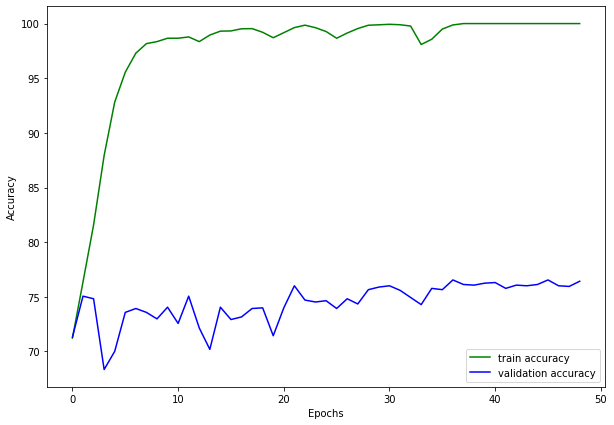

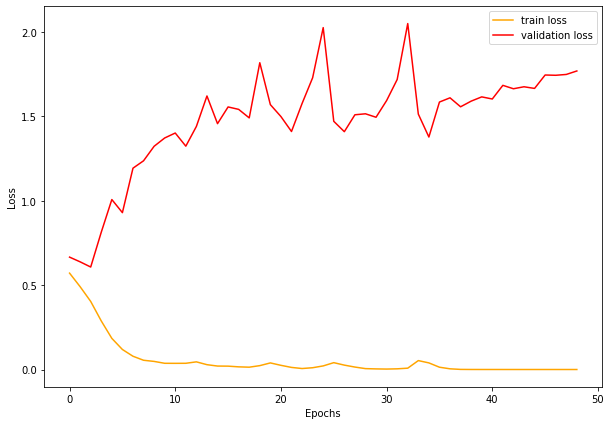

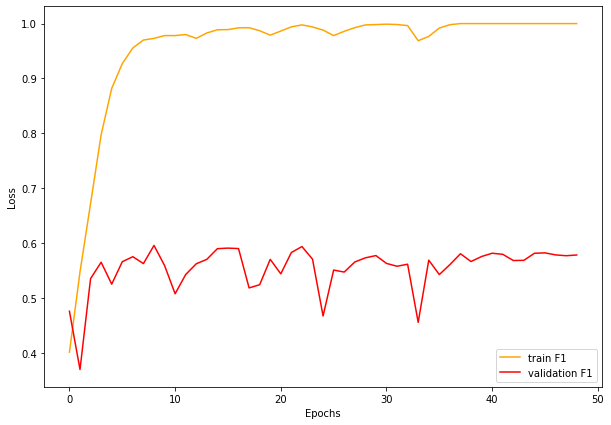

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
max(val_f1)

0.5955555555555555

In [ ]:
val_f1

[0.47557003257328995,
 0.36936936936936937,
 0.5350877192982456,
 0.5648979591836735,
 0.5249294449670743,
 0.5658536585365853,
 0.575024201355276,
 0.5624385447394297,
 0.5955555555555555,
 0.5590312815338042,
 0.5074626865671642,
 0.542483660130719,
 0.5620915032679739,
 0.5702054794520548,
 0.5896713615023474,
 0.5906642728904847,
 0.58983666061706,
 0.5181119648737651,
 0.5239130434782607,
 0.5701519213583558,
 0.5437499999999998,
 0.5826446280991736,
 0.5935114503816793,
 0.5705705705705705,
 0.466916354556804,
 0.5506653019447287,
 0.5470085470085471,
 0.5653923541247485,
 0.5729166666666666,
 0.5770833333333334,
 0.5627705627705627,
 0.5575888051668461,
 0.5613305613305613,
 0.45534591194968554,
 0.5687103594080338,
 0.5424107142857143,
 0.5606229143492769,
 0.580375782881002,
 0.5662002152852529,
 0.5753715498938429,
 0.5813221406086043,
 0.5793814432989691,
 0.5680600214362271,
 0.5683760683760682,
 0.5812499999999999,
 0.5820105820105821,
 0.5782881002087683,
 0.5768025078369

In [ ]:
blind_test_data = pano_images(xtest, ytest, tfms=0)
blindtestloader = DataLoader(blind_test_data, batch_size=200, shuffle=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/international_baseline_output/epoch8"))
validate(model, blindtestloader)






  0%|          | 0/8 [00:00<?, ?it/s]

Validating







 12%|█▎        | 1/8 [00:02<00:14,  2.02s/it]




 25%|██▌       | 2/8 [00:03<00:12,  2.01s/it]




 38%|███▊      | 3/8 [00:06<00:10,  2.02s/it]




 50%|█████     | 4/8 [00:08<00:08,  2.02s/it]




 62%|██████▎   | 5/8 [00:10<00:06,  2.05s/it]




 75%|███████▌  | 6/8 [00:12<00:04,  2.04s/it]




 88%|████████▊ | 7/8 [00:14<00:02,  2.03s/it]




100%|██████████| 8/8 [00:16<00:00,  2.02s/it]




9it [00:18,  2.02s/it]                       




10it [00:20,  2.01s/it]




11it [00:22,  2.01s/it]




12it [00:24,  2.01s/it]




13it [00:26,  2.01s/it]




14it [00:28,  2.01s/it]




15it [00:30,  2.01s/it]




16it [00:32,  2.03s/it]




17it [00:34,  2.03s/it]




18it [00:36,  2.01s/it]




19it [00:38,  2.01s/it]




20it [00:40,  2.00s/it]




21it [00:42,  2.00s/it]




22it [00:42,  1.93s/it]

Val Loss: 3.2024, Val Acc: 73.84
Recall: 0.6010, Precision: 0.53, F1: 0.57
TP 717 TN 2390 FP 625 FN 476


(3.202425628900528, 73.83555133079848, 0.565680473372781)

# RESNET BASELINE WITH MASK

In [2]:
!pip3 install torch==1.6.0 torchvision==0.7.0

In [3]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 5.7MB 1.0MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 112kB 7.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=7a60a62a23f6283be249ad59717bae636aac5efa9706bc59d896e4f2a0aa8153
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=349c1f4bf5a3457fa24474d3faf438381a6f13a3465eacd75c06fd8d2e1362b1
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built fvcore antlr4-python3-runtime


In [5]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from google.colab.patches import cv2_imshow
import requests
import cv2


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
# Load model cfg and weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_cafdb1.pkl: 261MB [00:24, 10.6MB/s]                           


In [7]:
def get_road(path):
  im = cv2.imread(path)
  panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
  new_dict = {}
  id = 999
  for item in segments_info:
   category_id = item['category_id']
   if category_id == 21:
     id = item['id']
  if id==999:
    print(path)
  road = (panoptic_seg==id)
  return road

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


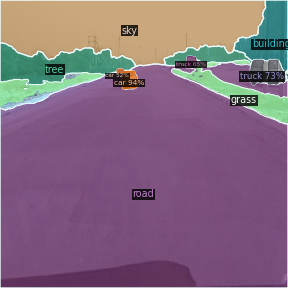

In [8]:
im = cv2.imread("/content/grddc_train/India/images/India_000016.jpg")
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.4)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image())

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0ad0dfc250>,
 <matplotlib.image.AxesImage at 0x7f0ad0dbac50>)

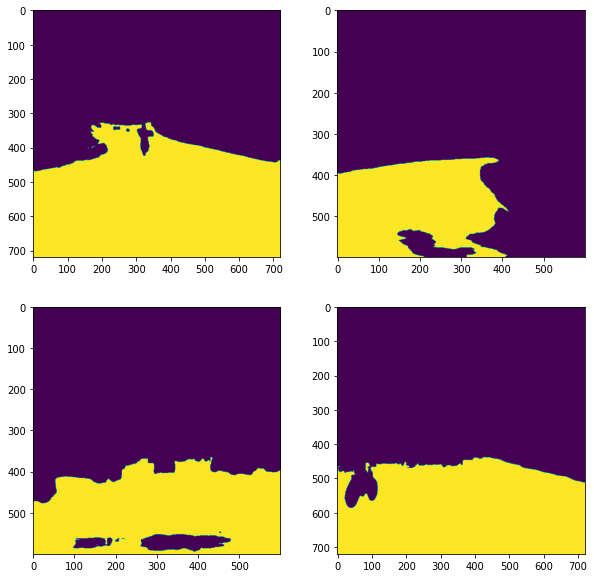

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(get_road("/content/grddc_train/India/images/India_000606.jpg").cpu())
plt.subplot(222), plt.imshow(get_road("/content/grddc_train/Czech/images/Czech_000606.jpg").cpu())
plt.subplot(223), plt.imshow(get_road("/content/grddc_train/Japan/images/Japan_001606.jpg").cpu())
plt.subplot(224), plt.imshow(get_road("/content/grddc_train/India/images/India_003606.jpg").cpu())

In [ ]:
i = -1
for path in tqdm(labelled_data['new_path']):
  i = i+1
  if i > -1:
    segmented_path = "/content/drive/MyDrive/Owen/international_images_segmented/" + str(path[21:])
    im = cv2.imread(path)
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    new_dict = {}
    id = 999
    for item in segments_info:
      category_id = item['category_id']
      if category_id == 21:
        id = item['id']
    if id==999:
      print(path)
    road = (panoptic_seg==id)
    road = np.repeat(road.cpu()[:, :, np.newaxis], 3, axis=2)
    newimage = np.array(road)*np.array(im)
    cv2.imwrite(segmented_path,newimage)

  0%|          | 97/21040 [00:13<46:02,  7.58it/s]

/content/grddc_train/Czech/images/Czech_002042.jpg


  1%|          | 148/21040 [00:19<44:40,  7.79it/s]

/content/grddc_train/Czech/images/Czech_001167.jpg


  2%|▏         | 357/21040 [00:47<45:37,  7.55it/s]

/content/grddc_train/Czech/images/Czech_003565.jpg


  2%|▏         | 509/21040 [01:07<44:40,  7.66it/s]

/content/grddc_train/Czech/images/Czech_001161.jpg


  3%|▎         | 624/21040 [01:22<47:22,  7.18it/s]

/content/grddc_train/Czech/images/Czech_002708.jpg


  3%|▎         | 697/21040 [01:32<43:29,  7.80it/s]

/content/grddc_train/Czech/images/Czech_002682.jpg


  3%|▎         | 736/21040 [01:37<43:41,  7.75it/s]

/content/grddc_train/Czech/images/Czech_002197.jpg


  5%|▌         | 1105/21040 [02:26<42:09,  7.88it/s]

/content/grddc_train/Czech/images/Czech_002436.jpg


  5%|▌         | 1145/21040 [02:31<44:11,  7.50it/s]

/content/grddc_train/Czech/images/Czech_003338.jpg


  6%|▌         | 1277/21040 [02:49<42:33,  7.74it/s]

/content/grddc_train/Czech/images/Czech_002804.jpg


  6%|▋         | 1356/21040 [02:59<42:34,  7.71it/s]

/content/grddc_train/Czech/images/Czech_001277.jpg


  6%|▋         | 1366/21040 [03:00<42:46,  7.66it/s]

/content/grddc_train/Czech/images/Czech_002742.jpg


  9%|▊         | 1838/21040 [04:03<42:02,  7.61it/s]

/content/grddc_train/Czech/images/Czech_002205.jpg


  9%|▉         | 1847/21040 [04:04<40:18,  7.94it/s]

/content/grddc_train/Czech/images/Czech_002775.jpg
/content/grddc_train/Czech/images/Czech_002013.jpg


  9%|▉         | 1906/21040 [04:12<40:28,  7.88it/s]

/content/grddc_train/Czech/images/Czech_002576.jpg


 10%|█         | 2147/21040 [04:43<41:30,  7.59it/s]

/content/grddc_train/Czech/images/Czech_000926.jpg


 11%|█         | 2259/21040 [04:58<39:18,  7.96it/s]

/content/grddc_train/Czech/images/Czech_000270.jpg


 13%|█▎        | 2637/21040 [05:48<40:47,  7.52it/s]

/content/grddc_train/Czech/images/Czech_002878.jpg


 14%|█▎        | 2857/21040 [06:17<41:26,  7.31it/s]

/content/grddc_train/India/images/India_000226.jpg


 15%|█▌        | 3261/21040 [07:14<41:09,  7.20it/s]

/content/grddc_train/India/images/India_008337.jpg


 19%|█▉        | 3954/21040 [08:50<38:51,  7.33it/s]

/content/grddc_train/India/images/India_000195.jpg


 19%|█▉        | 3974/21040 [08:53<39:14,  7.25it/s]

/content/grddc_train/India/images/India_004654.jpg


 20%|██        | 4272/21040 [09:35<38:04,  7.34it/s]

/content/grddc_train/India/images/India_006120.jpg


 22%|██▏       | 4608/21040 [10:22<36:58,  7.41it/s]

/content/grddc_train/India/images/India_004332.jpg


 22%|██▏       | 4678/21040 [10:31<36:36,  7.45it/s]

/content/grddc_train/India/images/India_004252.jpg


 24%|██▍       | 5035/21040 [11:21<36:42,  7.27it/s]

/content/grddc_train/India/images/India_005506.jpg


 24%|██▍       | 5053/21040 [11:24<35:47,  7.44it/s]

/content/grddc_train/India/images/India_000873.jpg


 25%|██▍       | 5155/21040 [11:38<35:50,  7.39it/s]

/content/grddc_train/India/images/India_001833.jpg


 25%|██▍       | 5180/21040 [11:41<36:36,  7.22it/s]

/content/grddc_train/India/images/India_009274.jpg


 25%|██▌       | 5308/21040 [11:59<34:37,  7.57it/s]

/content/grddc_train/India/images/India_000939.jpg


 26%|██▌       | 5470/21040 [12:22<35:54,  7.23it/s]

/content/grddc_train/India/images/India_009471.jpg


 26%|██▌       | 5520/21040 [12:29<34:26,  7.51it/s]

/content/grddc_train/India/images/India_002901.jpg


 27%|██▋       | 5602/21040 [12:40<35:09,  7.32it/s]

/content/grddc_train/India/images/India_009061.jpg


 28%|██▊       | 5828/21040 [13:12<33:32,  7.56it/s]

/content/grddc_train/India/images/India_006236.jpg


 29%|██▉       | 6169/21040 [13:59<34:31,  7.18it/s]

/content/grddc_train/India/images/India_003011.jpg


 30%|██▉       | 6211/21040 [14:05<33:00,  7.49it/s]

/content/grddc_train/India/images/India_001610.jpg


 32%|███▏      | 6655/21040 [15:07<32:25,  7.39it/s]

/content/grddc_train/India/images/India_002324.jpg


 32%|███▏      | 6671/21040 [15:09<32:42,  7.32it/s]

/content/grddc_train/India/images/India_001620.jpg


 32%|███▏      | 6690/21040 [15:12<33:10,  7.21it/s]

/content/grddc_train/India/images/India_006601.jpg


 32%|███▏      | 6735/21040 [15:18<34:52,  6.84it/s]

/content/grddc_train/India/images/India_008412.jpg


 32%|███▏      | 6755/21040 [15:21<33:23,  7.13it/s]

/content/grddc_train/India/images/India_002665.jpg


 33%|███▎      | 6969/21040 [15:51<34:15,  6.85it/s]

/content/grddc_train/India/images/India_008598.jpg


 34%|███▍      | 7110/21040 [16:10<31:09,  7.45it/s]

/content/grddc_train/India/images/India_005490.jpg


 34%|███▍      | 7155/21040 [16:17<31:17,  7.39it/s]

/content/grddc_train/India/images/India_007534.jpg


 35%|███▍      | 7259/21040 [16:31<31:02,  7.40it/s]

/content/grddc_train/India/images/India_005684.jpg


 35%|███▌      | 7390/21040 [16:49<30:17,  7.51it/s]

/content/grddc_train/India/images/India_008968.jpg


 36%|███▌      | 7562/21040 [17:13<31:30,  7.13it/s]

/content/grddc_train/India/images/India_001408.jpg


 37%|███▋      | 7760/21040 [17:41<30:09,  7.34it/s]

/content/grddc_train/India/images/India_000921.jpg


 37%|███▋      | 7796/21040 [17:46<30:48,  7.16it/s]

/content/grddc_train/India/images/India_007121.jpg


 38%|███▊      | 8077/21040 [18:25<31:03,  6.96it/s]

/content/grddc_train/India/images/India_004978.jpg


 39%|███▊      | 8107/21040 [18:29<29:16,  7.36it/s]

/content/grddc_train/India/images/India_005469.jpg


 39%|███▊      | 8117/21040 [18:30<29:38,  7.27it/s]

/content/grddc_train/India/images/India_004005.jpg


 39%|███▊      | 8134/21040 [18:33<29:09,  7.38it/s]

/content/grddc_train/India/images/India_003768.jpg


 39%|███▉      | 8270/21040 [18:51<29:18,  7.26it/s]

/content/grddc_train/India/images/India_000881.jpg


 40%|███▉      | 8389/21040 [19:08<30:15,  6.97it/s]

/content/grddc_train/India/images/India_001750.jpg


 40%|███▉      | 8400/21040 [19:10<28:43,  7.34it/s]

/content/grddc_train/India/images/India_002503.jpg


 41%|████      | 8621/21040 [19:40<28:52,  7.17it/s]

/content/grddc_train/India/images/India_000207.jpg


 43%|████▎     | 8986/21040 [20:31<27:47,  7.23it/s]

/content/grddc_train/India/images/India_004276.jpg


 44%|████▍     | 9228/21040 [21:05<27:11,  7.24it/s]

/content/grddc_train/India/images/India_000614.jpg


 44%|████▍     | 9265/21040 [21:10<26:44,  7.34it/s]

/content/grddc_train/India/images/India_001052.jpg


 45%|████▍     | 9378/21040 [21:26<27:39,  7.03it/s]

/content/grddc_train/India/images/India_007422.jpg


 45%|████▍     | 9395/21040 [21:28<26:09,  7.42it/s]

/content/grddc_train/India/images/India_002943.jpg


 45%|████▍     | 9403/21040 [21:30<26:58,  7.19it/s]

/content/grddc_train/India/images/India_006516.jpg


 48%|████▊     | 10125/21040 [23:10<25:05,  7.25it/s]

/content/grddc_train/India/images/India_006459.jpg


 49%|████▉     | 10281/21040 [23:32<24:32,  7.31it/s]

/content/grddc_train/India/images/India_005597.jpg


 50%|████▉     | 10440/21040 [23:53<24:03,  7.34it/s]

/content/grddc_train/India/images/India_007034.jpg


 50%|████▉     | 10446/21040 [23:54<24:13,  7.29it/s]

/content/grddc_train/India/images/India_005637.jpg


 50%|████▉     | 10456/21040 [23:56<24:37,  7.16it/s]

/content/grddc_train/India/images/India_006470.jpg


 50%|████▉     | 10480/21040 [23:59<25:30,  6.90it/s]

/content/grddc_train/India/images/India_001690.jpg


 51%|█████     | 10651/21040 [24:22<21:36,  8.01it/s]

/content/grddc_train/Japan/images/Japan_000531.jpg


 51%|█████     | 10684/21040 [24:26<22:23,  7.71it/s]

/content/grddc_train/Japan/images/Japan_011399.jpg


 51%|█████     | 10687/21040 [24:27<22:10,  7.78it/s]

/content/grddc_train/Japan/images/Japan_012848.jpg


 51%|█████     | 10704/21040 [24:29<21:21,  8.06it/s]

/content/grddc_train/Japan/images/Japan_008743.jpg


 51%|█████     | 10718/21040 [24:31<22:56,  7.50it/s]

/content/grddc_train/Japan/images/Japan_005515.jpg


 51%|█████▏    | 10783/21040 [24:39<21:52,  7.81it/s]

/content/grddc_train/Japan/images/Japan_004192.jpg


 51%|█████▏    | 10788/21040 [24:40<23:04,  7.41it/s]

/content/grddc_train/Japan/images/Japan_007114.jpg


 51%|█████▏    | 10796/21040 [24:41<22:57,  7.44it/s]

/content/grddc_train/Japan/images/Japan_011010.jpg


 52%|█████▏    | 10837/21040 [24:46<21:59,  7.73it/s]

/content/grddc_train/Japan/images/Japan_002905.jpg


 52%|█████▏    | 10889/21040 [24:53<21:37,  7.82it/s]

/content/grddc_train/Japan/images/Japan_011978.jpg


 52%|█████▏    | 10896/21040 [24:54<21:53,  7.72it/s]

/content/grddc_train/Japan/images/Japan_006545.jpg


 52%|█████▏    | 10926/21040 [24:58<22:54,  7.36it/s]

/content/grddc_train/Japan/images/Japan_009662.jpg


 52%|█████▏    | 10936/21040 [24:59<21:37,  7.79it/s]

/content/grddc_train/Japan/images/Japan_008554.jpg


 52%|█████▏    | 10997/21040 [25:07<21:10,  7.91it/s]

/content/grddc_train/Japan/images/Japan_002521.jpg


 52%|█████▎    | 11046/21040 [25:13<20:51,  7.99it/s]

/content/grddc_train/Japan/images/Japan_008805.jpg


 53%|█████▎    | 11078/21040 [25:17<21:21,  7.77it/s]

/content/grddc_train/Japan/images/Japan_004024.jpg


 53%|█████▎    | 11143/21040 [25:26<21:06,  7.82it/s]

/content/grddc_train/Japan/images/Japan_005879.jpg


 53%|█████▎    | 11171/21040 [25:29<21:15,  7.74it/s]

/content/grddc_train/Japan/images/Japan_002125.jpg


 53%|█████▎    | 11245/21040 [25:39<20:37,  7.92it/s]

/content/grddc_train/Japan/images/Japan_006427.jpg


 54%|█████▎    | 11289/21040 [25:45<20:30,  7.92it/s]

/content/grddc_train/Japan/images/Japan_011417.jpg


 54%|█████▍    | 11375/21040 [25:56<20:39,  7.80it/s]

/content/grddc_train/Japan/images/Japan_003167.jpg


 54%|█████▍    | 11431/21040 [26:03<20:06,  7.97it/s]

/content/grddc_train/Japan/images/Japan_003198.jpg


 54%|█████▍    | 11436/21040 [26:04<20:03,  7.98it/s]

/content/grddc_train/Japan/images/Japan_011588.jpg


 54%|█████▍    | 11443/21040 [26:05<20:00,  7.99it/s]

/content/grddc_train/Japan/images/Japan_004185.jpg


 54%|█████▍    | 11451/21040 [26:06<20:10,  7.92it/s]

/content/grddc_train/Japan/images/Japan_010319.jpg


 55%|█████▌    | 11621/21040 [26:28<19:53,  7.89it/s]

/content/grddc_train/Japan/images/Japan_010683.jpg


 56%|█████▌    | 11696/21040 [26:37<19:23,  8.03it/s]

/content/grddc_train/Japan/images/Japan_000282.jpg


 56%|█████▌    | 11698/21040 [26:38<19:13,  8.10it/s]

/content/grddc_train/Japan/images/Japan_002495.jpg


 56%|█████▌    | 11707/21040 [26:39<19:41,  7.90it/s]

/content/grddc_train/Japan/images/Japan_012862.jpg


 56%|█████▌    | 11746/21040 [26:44<20:24,  7.59it/s]

/content/grddc_train/Japan/images/Japan_004769.jpg


 56%|█████▌    | 11748/21040 [26:44<20:24,  7.59it/s]

/content/grddc_train/Japan/images/Japan_005311.jpg


 56%|█████▌    | 11755/21040 [26:45<19:20,  8.00it/s]

/content/grddc_train/Japan/images/Japan_007512.jpg


 56%|█████▌    | 11818/21040 [26:53<19:23,  7.92it/s]

/content/grddc_train/Japan/images/Japan_012309.jpg


 56%|█████▋    | 11843/21040 [26:57<19:22,  7.91it/s]

/content/grddc_train/Japan/images/Japan_009705.jpg


 56%|█████▋    | 11871/21040 [27:00<19:25,  7.87it/s]

/content/grddc_train/Japan/images/Japan_007714.jpg


 57%|█████▋    | 11903/21040 [27:04<19:12,  7.93it/s]

/content/grddc_train/Japan/images/Japan_006387.jpg


 57%|█████▋    | 11908/21040 [27:05<19:28,  7.81it/s]

/content/grddc_train/Japan/images/Japan_002687.jpg


 57%|█████▋    | 11932/21040 [27:08<19:34,  7.76it/s]

/content/grddc_train/Japan/images/Japan_012899.jpg


 57%|█████▋    | 11959/21040 [27:12<19:26,  7.79it/s]

/content/grddc_train/Japan/images/Japan_000279.jpg


 57%|█████▋    | 12012/21040 [27:18<19:59,  7.53it/s]

/content/grddc_train/Japan/images/Japan_004157.jpg


 57%|█████▋    | 12058/21040 [27:24<18:54,  7.92it/s]

/content/grddc_train/Japan/images/Japan_010687.jpg


 57%|█████▋    | 12096/21040 [27:29<19:16,  7.73it/s]

/content/grddc_train/Japan/images/Japan_002056.jpg


 58%|█████▊    | 12151/21040 [27:37<18:44,  7.91it/s]

/content/grddc_train/Japan/images/Japan_011957.jpg
/content/grddc_train/Japan/images/Japan_012286.jpg


 58%|█████▊    | 12182/21040 [27:41<18:45,  7.87it/s]

/content/grddc_train/Japan/images/Japan_004397.jpg


 58%|█████▊    | 12191/21040 [27:42<19:55,  7.40it/s]

/content/grddc_train/Japan/images/Japan_008220.jpg


 58%|█████▊    | 12226/21040 [27:46<18:50,  7.79it/s]

/content/grddc_train/Japan/images/Japan_010335.jpg


 58%|█████▊    | 12240/21040 [27:48<18:33,  7.90it/s]

/content/grddc_train/Japan/images/Japan_009116.jpg


 58%|█████▊    | 12271/21040 [27:52<18:46,  7.78it/s]

/content/grddc_train/Japan/images/Japan_006769.jpg


 59%|█████▊    | 12352/21040 [28:03<18:38,  7.77it/s]

/content/grddc_train/Japan/images/Japan_001614.jpg


 59%|█████▉    | 12396/21040 [28:08<17:45,  8.11it/s]

/content/grddc_train/Japan/images/Japan_010057.jpg


 59%|█████▉    | 12450/21040 [28:15<18:11,  7.87it/s]

/content/grddc_train/Japan/images/Japan_004552.jpg


 59%|█████▉    | 12453/21040 [28:16<19:11,  7.46it/s]

/content/grddc_train/Japan/images/Japan_004234.jpg


 60%|█████▉    | 12525/21040 [28:25<18:21,  7.73it/s]

/content/grddc_train/Japan/images/Japan_007717.jpg


 60%|█████▉    | 12546/21040 [28:28<18:45,  7.55it/s]

/content/grddc_train/Japan/images/Japan_007930.jpg


 60%|█████▉    | 12565/21040 [28:30<17:52,  7.90it/s]

/content/grddc_train/Japan/images/Japan_003983.jpg


 60%|█████▉    | 12580/21040 [28:32<18:13,  7.73it/s]

/content/grddc_train/Japan/images/Japan_004746.jpg


 60%|█████▉    | 12604/21040 [28:35<18:15,  7.70it/s]

/content/grddc_train/Japan/images/Japan_001164.jpg


 60%|██████    | 12647/21040 [28:41<18:19,  7.63it/s]

/content/grddc_train/Japan/images/Japan_006031.jpg


 60%|██████    | 12723/21040 [28:51<18:00,  7.70it/s]

/content/grddc_train/Japan/images/Japan_008785.jpg


 60%|██████    | 12728/21040 [28:52<17:40,  7.84it/s]

/content/grddc_train/Japan/images/Japan_004815.jpg


 61%|██████    | 12779/21040 [28:58<18:49,  7.32it/s]

/content/grddc_train/Japan/images/Japan_007105.jpg


 61%|██████    | 12790/21040 [29:00<17:26,  7.88it/s]

/content/grddc_train/Japan/images/Japan_004381.jpg


 61%|██████    | 12839/21040 [29:06<17:25,  7.84it/s]

/content/grddc_train/Japan/images/Japan_002929.jpg


 61%|██████    | 12886/21040 [29:12<16:52,  8.06it/s]

/content/grddc_train/Japan/images/Japan_005049.jpg


 61%|██████▏   | 12915/21040 [29:16<17:03,  7.94it/s]

/content/grddc_train/Japan/images/Japan_006959.jpg


 62%|██████▏   | 12970/21040 [29:23<16:53,  7.96it/s]

/content/grddc_train/Japan/images/Japan_012045.jpg


 62%|██████▏   | 13087/21040 [29:38<16:51,  7.86it/s]

/content/grddc_train/Japan/images/Japan_012482.jpg


 62%|██████▏   | 13092/21040 [29:39<17:00,  7.79it/s]

/content/grddc_train/Japan/images/Japan_007925.jpg


 62%|██████▏   | 13134/21040 [29:45<17:36,  7.48it/s]

/content/grddc_train/Japan/images/Japan_000045.jpg


 62%|██████▏   | 13148/21040 [29:46<16:55,  7.77it/s]

/content/grddc_train/Japan/images/Japan_006346.jpg


 63%|██████▎   | 13154/21040 [29:47<16:42,  7.86it/s]

/content/grddc_train/Japan/images/Japan_012333.jpg


 63%|██████▎   | 13173/21040 [29:50<16:48,  7.80it/s]

/content/grddc_train/Japan/images/Japan_001466.jpg


 63%|██████▎   | 13182/21040 [29:51<17:18,  7.56it/s]

/content/grddc_train/Japan/images/Japan_009984.jpg


 63%|██████▎   | 13184/21040 [29:51<16:52,  7.76it/s]

/content/grddc_train/Japan/images/Japan_012432.jpg


 63%|██████▎   | 13290/21040 [30:05<16:40,  7.75it/s]

/content/grddc_train/Japan/images/Japan_006137.jpg


 63%|██████▎   | 13345/21040 [30:12<16:33,  7.74it/s]

/content/grddc_train/Japan/images/Japan_004668.jpg


 64%|██████▎   | 13406/21040 [30:20<16:33,  7.68it/s]

/content/grddc_train/Japan/images/Japan_003477.jpg


 64%|██████▍   | 13462/21040 [30:27<16:04,  7.86it/s]

/content/grddc_train/Japan/images/Japan_002966.jpg


 64%|██████▍   | 13502/21040 [30:33<16:15,  7.73it/s]

/content/grddc_train/Japan/images/Japan_010422.jpg


 64%|██████▍   | 13517/21040 [30:34<17:01,  7.36it/s]

/content/grddc_train/Japan/images/Japan_006532.jpg


 65%|██████▍   | 13583/21040 [30:43<17:13,  7.21it/s]

/content/grddc_train/Japan/images/Japan_009417.jpg


 65%|██████▍   | 13586/21040 [30:44<16:24,  7.57it/s]

/content/grddc_train/Japan/images/Japan_002542.jpg
/content/grddc_train/Japan/images/Japan_012989.jpg


 65%|██████▍   | 13595/21040 [30:45<16:26,  7.54it/s]

/content/grddc_train/Japan/images/Japan_001739.jpg


 65%|██████▍   | 13599/21040 [30:45<15:56,  7.78it/s]

/content/grddc_train/Japan/images/Japan_002230.jpg


 65%|██████▌   | 13704/21040 [30:59<15:30,  7.88it/s]

/content/grddc_train/Japan/images/Japan_007200.jpg


 66%|██████▌   | 13851/21040 [31:18<16:28,  7.27it/s]

/content/grddc_train/Japan/images/Japan_011879.jpg


 66%|██████▌   | 13866/21040 [31:20<15:31,  7.70it/s]

/content/grddc_train/Japan/images/Japan_000948.jpg


 66%|██████▌   | 13874/21040 [31:21<15:23,  7.76it/s]

/content/grddc_train/Japan/images/Japan_002839.jpg


 66%|██████▋   | 13987/21040 [31:36<15:08,  7.77it/s]

/content/grddc_train/Japan/images/Japan_010622.jpg


 67%|██████▋   | 14010/21040 [31:39<14:47,  7.92it/s]

/content/grddc_train/Japan/images/Japan_010636.jpg


 67%|██████▋   | 14056/21040 [31:45<14:52,  7.83it/s]

/content/grddc_train/Japan/images/Japan_007160.jpg


 67%|██████▋   | 14087/21040 [31:49<14:52,  7.79it/s]

/content/grddc_train/Japan/images/Japan_006242.jpg


 67%|██████▋   | 14093/21040 [31:50<14:41,  7.88it/s]

/content/grddc_train/Japan/images/Japan_007148.jpg


 67%|██████▋   | 14095/21040 [31:50<15:25,  7.50it/s]

/content/grddc_train/Japan/images/Japan_002030.jpg


 67%|██████▋   | 14129/21040 [31:55<14:24,  7.99it/s]

/content/grddc_train/Japan/images/Japan_007835.jpg


 67%|██████▋   | 14137/21040 [31:56<14:22,  8.00it/s]

/content/grddc_train/Japan/images/Japan_002794.jpg


 67%|██████▋   | 14173/21040 [32:00<14:55,  7.67it/s]

/content/grddc_train/Japan/images/Japan_004332.jpg
/content/grddc_train/Japan/images/Japan_002743.jpg


 67%|██████▋   | 14195/21040 [32:03<14:51,  7.68it/s]

/content/grddc_train/Japan/images/Japan_012578.jpg


 67%|██████▋   | 14200/21040 [32:04<14:46,  7.71it/s]

/content/grddc_train/Japan/images/Japan_011065.jpg


 68%|██████▊   | 14206/21040 [32:04<14:38,  7.78it/s]

/content/grddc_train/Japan/images/Japan_003461.jpg


 68%|██████▊   | 14233/21040 [32:08<14:33,  7.79it/s]

/content/grddc_train/Japan/images/Japan_008087.jpg


 68%|██████▊   | 14255/21040 [32:11<14:41,  7.70it/s]

/content/grddc_train/Japan/images/Japan_012020.jpg


 68%|██████▊   | 14302/21040 [32:17<14:19,  7.84it/s]

/content/grddc_train/Japan/images/Japan_006684.jpg


 68%|██████▊   | 14367/21040 [32:25<14:40,  7.58it/s]

/content/grddc_train/Japan/images/Japan_005414.jpg


 68%|██████▊   | 14369/21040 [32:26<14:23,  7.73it/s]

/content/grddc_train/Japan/images/Japan_007203.jpg


 68%|██████▊   | 14385/21040 [32:28<14:00,  7.92it/s]

/content/grddc_train/Japan/images/Japan_000791.jpg


 68%|██████▊   | 14387/21040 [32:28<13:50,  8.02it/s]

/content/grddc_train/Japan/images/Japan_000949.jpg


 68%|██████▊   | 14400/21040 [32:30<14:05,  7.85it/s]

/content/grddc_train/Japan/images/Japan_012381.jpg


 69%|██████▊   | 14434/21040 [32:34<14:21,  7.67it/s]

/content/grddc_train/Japan/images/Japan_003529.jpg


 69%|██████▊   | 14448/21040 [32:36<14:12,  7.73it/s]

/content/grddc_train/Japan/images/Japan_002179.jpg
/content/grddc_train/Japan/images/Japan_005616.jpg


 69%|██████▉   | 14598/21040 [32:56<14:05,  7.62it/s]

/content/grddc_train/Japan/images/Japan_008134.jpg


 70%|██████▉   | 14631/21040 [33:00<13:22,  7.99it/s]

/content/grddc_train/Japan/images/Japan_004901.jpg


 70%|██████▉   | 14687/21040 [33:07<13:13,  8.00it/s]

/content/grddc_train/Japan/images/Japan_007415.jpg


 70%|███████   | 14810/21040 [33:23<13:17,  7.81it/s]

/content/grddc_train/Japan/images/Japan_012582.jpg


 70%|███████   | 14827/21040 [33:25<12:57,  7.99it/s]

/content/grddc_train/Japan/images/Japan_003470.jpg


 71%|███████   | 14908/21040 [33:36<13:09,  7.77it/s]

/content/grddc_train/Japan/images/Japan_001930.jpg


 71%|███████   | 14910/21040 [33:36<12:53,  7.92it/s]

/content/grddc_train/Japan/images/Japan_006087.jpg


 71%|███████   | 14984/21040 [33:46<13:18,  7.59it/s]

/content/grddc_train/Japan/images/Japan_006681.jpg


 72%|███████▏  | 15072/21040 [33:58<12:38,  7.87it/s]

/content/grddc_train/Japan/images/Japan_005820.jpg


 72%|███████▏  | 15104/21040 [34:02<13:16,  7.45it/s]

/content/grddc_train/Japan/images/Japan_007776.jpg


 72%|███████▏  | 15144/21040 [34:07<13:33,  7.25it/s]

/content/grddc_train/Japan/images/Japan_009767.jpg


 72%|███████▏  | 15173/21040 [34:11<12:42,  7.70it/s]

/content/grddc_train/Japan/images/Japan_010552.jpg


 73%|███████▎  | 15376/21040 [34:37<12:02,  7.84it/s]

/content/grddc_train/Japan/images/Japan_006085.jpg


 73%|███████▎  | 15390/21040 [34:39<13:16,  7.09it/s]

/content/grddc_train/Japan/images/Japan_005981.jpg


 73%|███████▎  | 15415/21040 [34:43<11:50,  7.92it/s]

/content/grddc_train/Japan/images/Japan_013107.jpg


 73%|███████▎  | 15446/21040 [34:47<11:47,  7.91it/s]

/content/grddc_train/Japan/images/Japan_000184.jpg


 73%|███████▎  | 15463/21040 [34:49<11:47,  7.88it/s]

/content/grddc_train/Japan/images/Japan_002963.jpg


 74%|███████▎  | 15503/21040 [34:54<12:05,  7.63it/s]

/content/grddc_train/Japan/images/Japan_001516.jpg


 74%|███████▍  | 15566/21040 [35:02<11:34,  7.89it/s]

/content/grddc_train/Japan/images/Japan_005599.jpg


 74%|███████▍  | 15613/21040 [35:08<12:25,  7.28it/s]

/content/grddc_train/Japan/images/Japan_012754.jpg


 74%|███████▍  | 15657/21040 [35:14<11:54,  7.53it/s]

/content/grddc_train/Japan/images/Japan_011498.jpg


 74%|███████▍  | 15659/21040 [35:14<11:49,  7.58it/s]

/content/grddc_train/Japan/images/Japan_001853.jpg


 75%|███████▍  | 15713/21040 [35:22<11:18,  7.85it/s]

/content/grddc_train/Japan/images/Japan_009943.jpg


 75%|███████▍  | 15733/21040 [35:24<11:38,  7.60it/s]

/content/grddc_train/Japan/images/Japan_005189.jpg


 75%|███████▍  | 15735/21040 [35:25<11:20,  7.80it/s]

/content/grddc_train/Japan/images/Japan_009980.jpg


 75%|███████▌  | 15830/21040 [35:37<11:09,  7.78it/s]

/content/grddc_train/Japan/images/Japan_002600.jpg


 76%|███████▌  | 15920/21040 [35:49<10:59,  7.76it/s]

/content/grddc_train/Japan/images/Japan_002402.jpg


 76%|███████▌  | 15946/21040 [35:52<11:10,  7.60it/s]

/content/grddc_train/Japan/images/Japan_001692.jpg


 76%|███████▋  | 16043/21040 [36:05<11:06,  7.50it/s]

/content/grddc_train/Japan/images/Japan_012956.jpg


 76%|███████▋  | 16053/21040 [36:06<10:54,  7.62it/s]

/content/grddc_train/Japan/images/Japan_009392.jpg


 76%|███████▋  | 16079/21040 [36:09<10:39,  7.76it/s]

/content/grddc_train/Japan/images/Japan_001255.jpg


 76%|███████▋  | 16094/21040 [36:11<10:49,  7.62it/s]

/content/grddc_train/Japan/images/Japan_010416.jpg


 77%|███████▋  | 16099/21040 [36:12<11:05,  7.43it/s]

/content/grddc_train/Japan/images/Japan_010402.jpg


 77%|███████▋  | 16124/21040 [36:15<10:27,  7.83it/s]

/content/grddc_train/Japan/images/Japan_001296.jpg


 77%|███████▋  | 16128/21040 [36:16<10:17,  7.96it/s]

/content/grddc_train/Japan/images/Japan_011913.jpg
/content/grddc_train/Japan/images/Japan_009184.jpg


 77%|███████▋  | 16159/21040 [36:20<10:33,  7.71it/s]

/content/grddc_train/Japan/images/Japan_004476.jpg


 77%|███████▋  | 16258/21040 [36:33<10:00,  7.97it/s]

/content/grddc_train/Japan/images/Japan_002211.jpg


 77%|███████▋  | 16278/21040 [36:36<10:16,  7.72it/s]

/content/grddc_train/Japan/images/Japan_005230.jpg


 77%|███████▋  | 16285/21040 [36:36<09:48,  8.08it/s]

/content/grddc_train/Japan/images/Japan_002239.jpg


 78%|███████▊  | 16339/21040 [36:43<10:27,  7.49it/s]

/content/grddc_train/Japan/images/Japan_002365.jpg


 78%|███████▊  | 16356/21040 [36:46<10:29,  7.44it/s]

/content/grddc_train/Japan/images/Japan_001122.jpg


 78%|███████▊  | 16361/21040 [36:46<09:57,  7.83it/s]

/content/grddc_train/Japan/images/Japan_005344.jpg


 78%|███████▊  | 16384/21040 [36:49<09:47,  7.92it/s]

/content/grddc_train/Japan/images/Japan_009783.jpg
/content/grddc_train/Japan/images/Japan_007962.jpg


 78%|███████▊  | 16493/21040 [37:03<09:31,  7.96it/s]

/content/grddc_train/Japan/images/Japan_009742.jpg


 78%|███████▊  | 16504/21040 [37:05<09:47,  7.72it/s]

/content/grddc_train/Japan/images/Japan_000772.jpg


 79%|███████▊  | 16545/21040 [37:10<10:18,  7.27it/s]

/content/grddc_train/Japan/images/Japan_005420.jpg


 79%|███████▊  | 16567/21040 [37:13<09:19,  7.99it/s]

/content/grddc_train/Japan/images/Japan_012160.jpg


 79%|███████▉  | 16586/21040 [37:15<09:19,  7.96it/s]

/content/grddc_train/Japan/images/Japan_001108.jpg


 79%|███████▉  | 16611/21040 [37:19<09:33,  7.72it/s]

/content/grddc_train/Japan/images/Japan_010944.jpg


 79%|███████▉  | 16623/21040 [37:20<09:36,  7.66it/s]

/content/grddc_train/Japan/images/Japan_008689.jpg


 79%|███████▉  | 16719/21040 [37:33<09:12,  7.82it/s]

/content/grddc_train/Japan/images/Japan_001524.jpg


 80%|███████▉  | 16736/21040 [37:35<09:18,  7.71it/s]

/content/grddc_train/Japan/images/Japan_010367.jpg


 80%|███████▉  | 16776/21040 [37:40<09:00,  7.89it/s]

/content/grddc_train/Japan/images/Japan_002978.jpg


 80%|███████▉  | 16805/21040 [37:44<09:03,  7.80it/s]

/content/grddc_train/Japan/images/Japan_005794.jpg


 80%|███████▉  | 16826/21040 [37:47<09:02,  7.77it/s]

/content/grddc_train/Japan/images/Japan_008529.jpg


 80%|████████  | 16833/21040 [37:48<08:57,  7.83it/s]

/content/grddc_train/Japan/images/Japan_010400.jpg


 80%|████████  | 16849/21040 [37:50<08:56,  7.82it/s]

/content/grddc_train/Japan/images/Japan_002992.jpg


 80%|████████  | 16881/21040 [37:54<09:40,  7.17it/s]

/content/grddc_train/Japan/images/Japan_007395.jpg


 81%|████████  | 16948/21040 [38:03<08:41,  7.85it/s]

/content/grddc_train/Japan/images/Japan_005233.jpg


 81%|████████  | 17000/21040 [38:09<08:31,  7.90it/s]

/content/grddc_train/Japan/images/Japan_000565.jpg


 81%|████████  | 17035/21040 [38:14<08:51,  7.53it/s]

/content/grddc_train/Japan/images/Japan_008663.jpg


 81%|████████  | 17049/21040 [38:16<08:15,  8.06it/s]

/content/grddc_train/Japan/images/Japan_011681.jpg


 81%|████████  | 17055/21040 [38:17<08:32,  7.77it/s]

/content/grddc_train/Japan/images/Japan_002825.jpg


 81%|████████▏ | 17109/21040 [38:24<09:07,  7.18it/s]

/content/grddc_train/Japan/images/Japan_011124.jpg


 81%|████████▏ | 17115/21040 [38:25<08:33,  7.65it/s]

/content/grddc_train/Japan/images/Japan_008461.jpg


 81%|████████▏ | 17123/21040 [38:26<08:38,  7.56it/s]

/content/grddc_train/Japan/images/Japan_010548.jpg


 82%|████████▏ | 17149/21040 [38:29<08:07,  7.98it/s]

/content/grddc_train/Japan/images/Japan_007018.jpg


 82%|████████▏ | 17169/21040 [38:32<08:21,  7.72it/s]

/content/grddc_train/Japan/images/Japan_005141.jpg


 82%|████████▏ | 17242/21040 [38:41<08:00,  7.90it/s]

/content/grddc_train/Japan/images/Japan_005343.jpg


 82%|████████▏ | 17253/21040 [38:43<08:25,  7.49it/s]

/content/grddc_train/Japan/images/Japan_012159.jpg


 82%|████████▏ | 17317/21040 [38:51<08:15,  7.52it/s]

/content/grddc_train/Japan/images/Japan_004101.jpg


 82%|████████▏ | 17328/21040 [38:52<07:46,  7.95it/s]

/content/grddc_train/Japan/images/Japan_002558.jpg


 82%|████████▏ | 17347/21040 [38:55<08:09,  7.54it/s]

/content/grddc_train/Japan/images/Japan_011256.jpg


 83%|████████▎ | 17361/21040 [38:57<07:49,  7.84it/s]

/content/grddc_train/Japan/images/Japan_009380.jpg


 83%|████████▎ | 17416/21040 [39:04<07:46,  7.77it/s]

/content/grddc_train/Japan/images/Japan_007144.jpg


 83%|████████▎ | 17512/21040 [39:16<07:24,  7.93it/s]

/content/grddc_train/Japan/images/Japan_007145.jpg


 83%|████████▎ | 17567/21040 [39:24<07:49,  7.39it/s]

/content/grddc_train/Japan/images/Japan_001093.jpg


 84%|████████▎ | 17579/21040 [39:25<07:34,  7.61it/s]

/content/grddc_train/Japan/images/Japan_003860.jpg


 84%|████████▎ | 17618/21040 [39:30<07:43,  7.38it/s]

/content/grddc_train/Japan/images/Japan_010175.jpg


 84%|████████▍ | 17630/21040 [39:32<07:14,  7.84it/s]

/content/grddc_train/Japan/images/Japan_009430.jpg


 84%|████████▍ | 17653/21040 [39:35<07:08,  7.91it/s]

/content/grddc_train/Japan/images/Japan_011492.jpg


 84%|████████▍ | 17663/21040 [39:36<07:37,  7.39it/s]

/content/grddc_train/Japan/images/Japan_008855.jpg


 84%|████████▍ | 17684/21040 [39:39<07:08,  7.84it/s]

/content/grddc_train/Japan/images/Japan_011323.jpg


 84%|████████▍ | 17770/21040 [39:50<06:55,  7.87it/s]

/content/grddc_train/Japan/images/Japan_005140.jpg


 85%|████████▍ | 17871/21040 [40:03<06:40,  7.92it/s]

/content/grddc_train/Japan/images/Japan_013091.jpg


 85%|████████▌ | 17884/21040 [40:05<07:12,  7.29it/s]

/content/grddc_train/Japan/images/Japan_006488.jpg


 85%|████████▌ | 17921/21040 [40:10<06:40,  7.79it/s]

/content/grddc_train/Japan/images/Japan_002413.jpg


 85%|████████▌ | 17952/21040 [40:14<06:32,  7.87it/s]

/content/grddc_train/Japan/images/Japan_001867.jpg


 86%|████████▌ | 18004/21040 [40:21<06:34,  7.70it/s]

/content/grddc_train/Japan/images/Japan_003651.jpg


 86%|████████▌ | 18012/21040 [40:22<06:14,  8.08it/s]

/content/grddc_train/Japan/images/Japan_008062.jpg


 86%|████████▌ | 18062/21040 [40:28<06:26,  7.70it/s]

/content/grddc_train/Japan/images/Japan_002765.jpg


 86%|████████▌ | 18133/21040 [40:38<06:10,  7.85it/s]

/content/grddc_train/Japan/images/Japan_011081.jpg


 86%|████████▌ | 18136/21040 [40:38<06:11,  7.82it/s]

/content/grddc_train/Japan/images/Japan_002943.jpg


 86%|████████▋ | 18170/21040 [40:43<06:35,  7.26it/s]

/content/grddc_train/Japan/images/Japan_007152.jpg


 87%|████████▋ | 18225/21040 [40:50<06:02,  7.77it/s]

/content/grddc_train/Japan/images/Japan_003877.jpg


 87%|████████▋ | 18247/21040 [40:53<06:24,  7.26it/s]

/content/grddc_train/Japan/images/Japan_007436.jpg


 87%|████████▋ | 18279/21040 [40:57<05:56,  7.75it/s]

/content/grddc_train/Japan/images/Japan_004103.jpg


 87%|████████▋ | 18362/21040 [41:08<06:06,  7.30it/s]

/content/grddc_train/Japan/images/Japan_010764.jpg


 87%|████████▋ | 18404/21040 [41:14<05:52,  7.48it/s]

/content/grddc_train/Japan/images/Japan_006338.jpg


 88%|████████▊ | 18420/21040 [41:16<05:34,  7.82it/s]

/content/grddc_train/Japan/images/Japan_001319.jpg


 88%|████████▊ | 18424/21040 [41:16<05:25,  8.04it/s]

/content/grddc_train/Japan/images/Japan_004507.jpg
/content/grddc_train/Japan/images/Japan_012365.jpg


 88%|████████▊ | 18458/21040 [41:21<05:49,  7.38it/s]

/content/grddc_train/Japan/images/Japan_005130.jpg


 88%|████████▊ | 18461/21040 [41:21<05:33,  7.73it/s]

/content/grddc_train/Japan/images/Japan_005124.jpg


 88%|████████▊ | 18503/21040 [41:27<05:24,  7.82it/s]

/content/grddc_train/Japan/images/Japan_003582.jpg


 88%|████████▊ | 18544/21040 [41:32<05:22,  7.75it/s]

/content/grddc_train/Japan/images/Japan_005440.jpg


 88%|████████▊ | 18552/21040 [41:33<05:33,  7.45it/s]

/content/grddc_train/Japan/images/Japan_011353.jpg


 88%|████████▊ | 18569/21040 [41:35<05:29,  7.49it/s]

/content/grddc_train/Japan/images/Japan_006175.jpg


 88%|████████▊ | 18611/21040 [41:41<05:12,  7.77it/s]

/content/grddc_train/Japan/images/Japan_003637.jpg


 89%|████████▊ | 18621/21040 [41:42<05:15,  7.66it/s]

/content/grddc_train/Japan/images/Japan_011555.jpg


 89%|████████▊ | 18652/21040 [41:46<05:15,  7.57it/s]

/content/grddc_train/Japan/images/Japan_006001.jpg


 89%|████████▉ | 18820/21040 [42:08<05:08,  7.20it/s]

/content/grddc_train/Japan/images/Japan_001237.jpg


 90%|████████▉ | 18837/21040 [42:10<04:44,  7.75it/s]

/content/grddc_train/Japan/images/Japan_000883.jpg


 90%|████████▉ | 18844/21040 [42:11<04:47,  7.64it/s]

/content/grddc_train/Japan/images/Japan_011030.jpg


 90%|████████▉ | 18890/21040 [42:17<04:46,  7.50it/s]

/content/grddc_train/Japan/images/Japan_001009.jpg


 90%|█████████ | 18950/21040 [42:25<04:29,  7.74it/s]

/content/grddc_train/Japan/images/Japan_003781.jpg


 90%|█████████ | 18957/21040 [42:26<04:48,  7.23it/s]

/content/grddc_train/Japan/images/Japan_004788.jpg


 90%|█████████ | 18960/21040 [42:26<04:26,  7.81it/s]

/content/grddc_train/Japan/images/Japan_004763.jpg


 90%|█████████ | 19025/21040 [42:35<04:16,  7.85it/s]

/content/grddc_train/Japan/images/Japan_009092.jpg


 91%|█████████ | 19051/21040 [42:38<04:28,  7.41it/s]

/content/grddc_train/Japan/images/Japan_003568.jpg


 91%|█████████ | 19067/21040 [42:40<04:19,  7.61it/s]

/content/grddc_train/Japan/images/Japan_006362.jpg


 91%|█████████ | 19075/21040 [42:41<04:15,  7.71it/s]

/content/grddc_train/Japan/images/Japan_012471.jpg


 91%|█████████ | 19087/21040 [42:43<04:18,  7.55it/s]

/content/grddc_train/Japan/images/Japan_008367.jpg


 91%|█████████ | 19106/21040 [42:46<03:59,  8.08it/s]

/content/grddc_train/Japan/images/Japan_008365.jpg


 91%|█████████ | 19164/21040 [42:53<04:01,  7.78it/s]

/content/grddc_train/Japan/images/Japan_007095.jpg


 91%|█████████▏| 19225/21040 [43:01<03:57,  7.65it/s]

/content/grddc_train/Japan/images/Japan_007268.jpg


 91%|█████████▏| 19235/21040 [43:02<03:51,  7.78it/s]

/content/grddc_train/Japan/images/Japan_006604.jpg


 92%|█████████▏| 19267/21040 [43:07<03:45,  7.87it/s]

/content/grddc_train/Japan/images/Japan_007446.jpg


 92%|█████████▏| 19330/21040 [43:15<03:43,  7.65it/s]

/content/grddc_train/Japan/images/Japan_011595.jpg


 92%|█████████▏| 19422/21040 [43:27<03:30,  7.70it/s]

/content/grddc_train/Japan/images/Japan_011972.jpg


 92%|█████████▏| 19439/21040 [43:29<03:25,  7.77it/s]

/content/grddc_train/Japan/images/Japan_002098.jpg


 93%|█████████▎| 19531/21040 [43:41<03:13,  7.78it/s]

/content/grddc_train/Japan/images/Japan_003609.jpg


 93%|█████████▎| 19565/21040 [43:46<03:15,  7.54it/s]

/content/grddc_train/Japan/images/Japan_005244.jpg


 93%|█████████▎| 19577/21040 [43:47<03:13,  7.57it/s]

/content/grddc_train/Japan/images/Japan_008012.jpg


 93%|█████████▎| 19597/21040 [43:50<03:10,  7.58it/s]

/content/grddc_train/Japan/images/Japan_001195.jpg


 93%|█████████▎| 19599/21040 [43:50<03:09,  7.62it/s]

/content/grddc_train/Japan/images/Japan_011392.jpg


 94%|█████████▎| 19714/21040 [44:06<02:52,  7.71it/s]

/content/grddc_train/Japan/images/Japan_013036.jpg


 94%|█████████▍| 19726/21040 [44:07<02:50,  7.69it/s]

/content/grddc_train/Japan/images/Japan_007057.jpg


 94%|█████████▍| 19766/21040 [44:13<02:40,  7.92it/s]

/content/grddc_train/Japan/images/Japan_008406.jpg


 94%|█████████▍| 19786/21040 [44:15<02:44,  7.62it/s]

/content/grddc_train/Japan/images/Japan_008412.jpg


 94%|█████████▍| 19809/21040 [44:18<02:41,  7.63it/s]

/content/grddc_train/Japan/images/Japan_007084.jpg
/content/grddc_train/Japan/images/Japan_005693.jpg


 95%|█████████▍| 19911/21040 [44:32<02:29,  7.58it/s]

/content/grddc_train/Japan/images/Japan_000310.jpg


 95%|█████████▍| 19941/21040 [44:36<02:27,  7.46it/s]

/content/grddc_train/Japan/images/Japan_000338.jpg


 95%|█████████▍| 19951/21040 [44:37<02:18,  7.84it/s]

/content/grddc_train/Japan/images/Japan_009491.jpg


 95%|█████████▍| 19954/21040 [44:38<02:18,  7.84it/s]

/content/grddc_train/Japan/images/Japan_001967.jpg


 95%|█████████▍| 19963/21040 [44:39<02:19,  7.74it/s]

/content/grddc_train/Japan/images/Japan_006946.jpg


 95%|█████████▍| 19969/21040 [44:40<02:14,  7.97it/s]

/content/grddc_train/Japan/images/Japan_001783.jpg


 95%|█████████▌| 19993/21040 [44:43<02:13,  7.85it/s]

/content/grddc_train/Japan/images/Japan_009644.jpg


 95%|█████████▌| 19997/21040 [44:43<02:17,  7.59it/s]

/content/grddc_train/Japan/images/Japan_008572.jpg


 95%|█████████▌| 20003/21040 [44:44<02:11,  7.90it/s]

/content/grddc_train/Japan/images/Japan_011745.jpg


 95%|█████████▌| 20063/21040 [44:52<02:08,  7.63it/s]

/content/grddc_train/Japan/images/Japan_007873.jpg


 95%|█████████▌| 20081/21040 [44:54<02:00,  7.95it/s]

/content/grddc_train/Japan/images/Japan_011022.jpg


 96%|█████████▌| 20111/21040 [44:58<01:57,  7.94it/s]

/content/grddc_train/Japan/images/Japan_002704.jpg


 96%|█████████▌| 20179/21040 [45:07<01:58,  7.28it/s]

/content/grddc_train/Japan/images/Japan_003624.jpg


 96%|█████████▌| 20201/21040 [45:10<01:49,  7.64it/s]

/content/grddc_train/Japan/images/Japan_002260.jpg


 96%|█████████▋| 20258/21040 [45:18<01:40,  7.74it/s]

/content/grddc_train/Japan/images/Japan_004759.jpg


 96%|█████████▋| 20270/21040 [45:19<01:37,  7.88it/s]

/content/grddc_train/Japan/images/Japan_006600.jpg


 97%|█████████▋| 20338/21040 [45:28<01:32,  7.62it/s]

/content/grddc_train/Japan/images/Japan_010248.jpg


 97%|█████████▋| 20350/21040 [45:30<01:28,  7.79it/s]

/content/grddc_train/Japan/images/Japan_007052.jpg


 97%|█████████▋| 20363/21040 [45:31<01:28,  7.61it/s]

/content/grddc_train/Japan/images/Japan_002664.jpg


 97%|█████████▋| 20394/21040 [45:35<01:22,  7.86it/s]

/content/grddc_train/Japan/images/Japan_012307.jpg


 97%|█████████▋| 20437/21040 [45:41<01:23,  7.24it/s]

/content/grddc_train/Japan/images/Japan_009928.jpg


 97%|█████████▋| 20458/21040 [45:44<01:15,  7.69it/s]

/content/grddc_train/Japan/images/Japan_005684.jpg


 97%|█████████▋| 20467/21040 [45:45<01:13,  7.76it/s]

/content/grddc_train/Japan/images/Japan_002302.jpg


 97%|█████████▋| 20478/21040 [45:47<01:15,  7.44it/s]

/content/grddc_train/Japan/images/Japan_004001.jpg


 98%|█████████▊| 20576/21040 [45:59<01:01,  7.49it/s]

/content/grddc_train/Japan/images/Japan_008001.jpg


 98%|█████████▊| 20650/21040 [46:09<00:54,  7.21it/s]

/content/grddc_train/Japan/images/Japan_002074.jpg


 98%|█████████▊| 20694/21040 [46:15<00:43,  7.97it/s]

/content/grddc_train/Japan/images/Japan_005900.jpg


 98%|█████████▊| 20701/21040 [46:16<00:42,  7.96it/s]

/content/grddc_train/Japan/images/Japan_007695.jpg


 98%|█████████▊| 20709/21040 [46:17<00:41,  8.02it/s]

/content/grddc_train/Japan/images/Japan_000688.jpg


 98%|█████████▊| 20714/21040 [46:18<00:43,  7.50it/s]

/content/grddc_train/Japan/images/Japan_007681.jpg


 99%|█████████▉| 20784/21040 [46:27<00:33,  7.56it/s]

/content/grddc_train/Japan/images/Japan_002713.jpg


 99%|█████████▉| 20823/21040 [46:32<00:27,  7.96it/s]

/content/grddc_train/Japan/images/Japan_003627.jpg


 99%|█████████▉| 20854/21040 [46:36<00:23,  7.81it/s]

/content/grddc_train/Japan/images/Japan_002505.jpg


 99%|█████████▉| 20871/21040 [46:38<00:22,  7.44it/s]

/content/grddc_train/Japan/images/Japan_012702.jpg


 99%|█████████▉| 20884/21040 [46:40<00:19,  7.96it/s]

/content/grddc_train/Japan/images/Japan_010920.jpg


 99%|█████████▉| 20892/21040 [46:41<00:21,  6.79it/s]

/content/grddc_train/Japan/images/Japan_008809.jpg


 99%|█████████▉| 20924/21040 [46:45<00:16,  7.25it/s]

/content/grddc_train/Japan/images/Japan_001150.jpg


100%|█████████▉| 20940/21040 [46:47<00:13,  7.55it/s]

/content/grddc_train/Japan/images/Japan_002317.jpg


100%|█████████▉| 20944/21040 [46:48<00:12,  7.68it/s]

/content/grddc_train/Japan/images/Japan_010713.jpg


100%|█████████▉| 20995/21040 [46:55<00:05,  7.66it/s]

/content/grddc_train/Japan/images/Japan_006429.jpg


100%|█████████▉| 21002/21040 [46:56<00:04,  7.86it/s]

/content/grddc_train/Japan/images/Japan_003545.jpg


100%|█████████▉| 21018/21040 [46:58<00:02,  7.91it/s]

/content/grddc_train/Japan/images/Japan_004564.jpg


100%|██████████| 21040/21040 [47:01<00:00,  7.46it/s]


In [18]:
path = "/content/grddc_train/Czech/images/Czech_001364.jpg"
segmented_path = "/content/drive/MyDrive/Owen/international_images_segmented/" + str(path[21:])
im = cv2.imread(path)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
new_dict = {}
id = 999
for item in segments_info:
  category_id = item['category_id']
if category_id == 21:
  id = item['id']
if id==999:
  print(path)
road = (panoptic_seg==id)
road = np.repeat(road.cpu()[:, :, np.newaxis], 3, axis=2)
newimage = np.array(road)*np.array(im)
cv2.imwrite(segmented_path,newimage)

/content/grddc_train/Czech/images/Czech_001364.jpg


True

In [17]:
labelled_data.head()

,image,country,oldpath,box,cracking_binary,new_path,segmented_image_path
0,Czech_003573,Czech,/Users/owenwinter/GRDDC/Czech_003573.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003573...,/content/drive/MyDrive/Owen/international_imag...
1,Czech_003215,Czech,/Users/owenwinter/GRDDC/Czech_003215.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003215...,/content/drive/MyDrive/Owen/international_imag...
2,Czech_000708,Czech,/Users/owenwinter/GRDDC/Czech_000708.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_000708...,/content/drive/MyDrive/Owen/international_imag...
3,Czech_003201,Czech,/Users/owenwinter/GRDDC/Czech_003201.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003201...,/content/drive/MyDrive/Owen/international_imag...
4,Czech_002679,Czech,/Users/owenwinter/GRDDC/Czech_002679.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_002679...,/content/drive/MyDrive/Owen/international_imag...


In [16]:
labelled_data['segmented_image_path'] = "/content/drive/MyDrive/Owen/international_images_segmented/" + labelled_data['country'].astype("str") + "/images/" + labelled_data['image'].astype("str") + ".jpg"

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(labelled_data['segmented_image_path'].values, labelled_data['cracking_binary'].values, test_size=0.2, random_state=42)

In [ ]:
xtrain, xval, ytrain, yval= train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

In [ ]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = pano_images(xtrain, ytrain, tfms=1)
test_data = pano_images(xval, yval, tfms=0)

trainloader = DataLoader(train_data, batch_size=200, shuffle=True)
testloader = DataLoader(test_data, batch_size=200, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6570973e50>,
 <matplotlib.image.AxesImage at 0x7f6570bcbed0>)

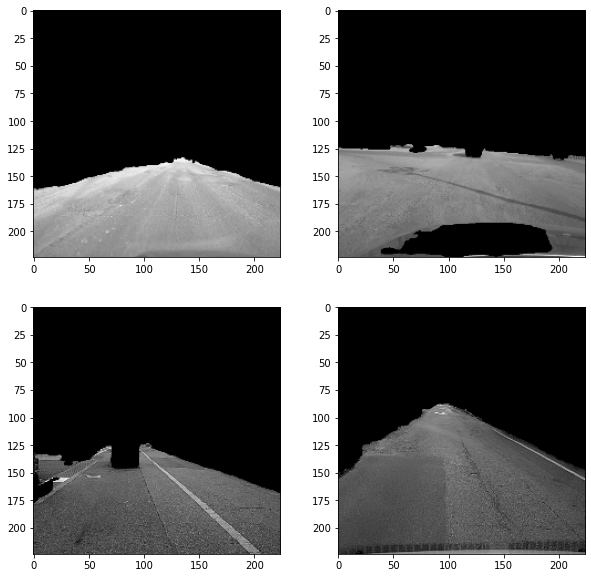

In [ ]:
# visualizing images
i = 50
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_data[i][0][1], cmap='gray')
plt.subplot(222), plt.imshow(train_data[i+25][0][1], cmap='gray')
plt.subplot(223), plt.imshow(train_data[i+50][0][1], cmap='gray')
plt.subplot(224), plt.imshow(train_data[i+75][0][1], cmap='gray')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
# defining the model
model = models.resnet34(pretrained=True)
#set_parameter_requires_grad(model,0)
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        if true_positives+false_positives>0:
          precision = true_positives/(true_positives+false_positives)
        else:
          precision = 0
        recall = true_positives/(true_positives+false_negatives)
        if ((precision>0)&(recall>0)):
          f1 = 2 * (precision*recall)/(precision+recall)
        else:
          f1 = 0
        val_loss = val_running_loss/max(int(len(test_data)/test_dataloader.batch_size),1)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        print("TP",true_positives,"TN",true_negatives,"FP",false_positives,"FN",false_negatives)
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    
    if true_positives+false_positives>0:
      precision = true_positives/(true_positives+false_positives)
    else:
      precision = 0
    recall = true_positives/(true_positives+false_negatives)
    if ((precision>0)&(recall>0)):
      f1 = 2 * (precision*recall)/(precision+recall)
    else:
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/resnet_mask_multiplied_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")



  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1 of 75
Training




  1%|▏         | 1/75 [00:02<03:03,  2.48s/it]

  3%|▎         | 2/75 [00:04<02:58,  2.45s/it]

  4%|▍         | 3/75 [00:07<02:53,  2.41s/it]

  5%|▌         | 4/75 [00:09<02:48,  2.37s/it]

  7%|▋         | 5/75 [00:11<02:44,  2.36s/it]

  8%|▊         | 6/75 [00:14<02:41,  2.34s/it]

  9%|▉         | 7/75 [00:16<02:38,  2.34s/it]

 11%|█         | 8/75 [00:18<02:36,  2.33s/it]

 12%|█▏        | 9/75 [00:21<02:34,  2.34s/it]

 13%|█▎        | 10/75 [00:23<02:31,  2.33s/it]

 15%|█▍        | 11/75 [00:25<02:27,  2.31s/it]

 16%|█▌        | 12/75 [00:27<02:25,  2.31s/it]

 17%|█▋        | 13/75 [00:30<02:23,  2.31s/it]

 19%|█▊        | 14/75 [00:32<02:20,  2.30s/it]

 20%|██        | 15/75 [00:34<02:17,  2.30s/it]

 21%|██▏       | 16/75 [00:37<02:15,  2.30s/it]

 23%|██▎       | 17/75 [00:39<02:14,  2.32s/it]

 24%|██▍       | 18/75 [00:41<02:12,  2.32s/it]

 25%|██▌       | 19/75 [00:44<02:09,  2.31s/it]

 27%|██▋       | 20/75 [00:46<02:07,  2.32s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.5757, Train Acc: 71.12
Recall: 0.2668, Precision: 0.56, F1: 0.36
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.12s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.12s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.12s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.12s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.13s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.16s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.15s/it]

100%|██████████| 8/8 [00:17<00:00,  2.16s/it]

9it [00:18,  2.01s/it]


Val Loss: 0.6230, Val Acc: 71.26
Recall: 0.3851, Precision: 0.53, F1: 0.45
TP 196 TN 1004 FP 171 FN 313




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2 of 75
Training




  1%|▏         | 1/75 [00:02<02:52,  2.33s/it]

  3%|▎         | 2/75 [00:04<02:49,  2.32s/it]

  4%|▍         | 3/75 [00:06<02:46,  2.31s/it]

  5%|▌         | 4/75 [00:09<02:45,  2.33s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.31s/it]

  9%|▉         | 7/75 [00:16<02:37,  2.31s/it]

 11%|█         | 8/75 [00:18<02:34,  2.30s/it]

 12%|█▏        | 9/75 [00:20<02:32,  2.30s/it]

 13%|█▎        | 10/75 [00:23<02:30,  2.31s/it]

 15%|█▍        | 11/75 [00:25<02:26,  2.29s/it]

 16%|█▌        | 12/75 [00:27<02:24,  2.29s/it]

 17%|█▋        | 13/75 [00:29<02:21,  2.28s/it]

 19%|█▊        | 14/75 [00:32<02:19,  2.28s/it]

 20%|██        | 15/75 [00:34<02:17,  2.28s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.28s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:41<02:09,  2.28s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.28s/it]

 27%|██▋       | 20/75 [00:45<02:05,  2.29s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.5219, Train Acc: 74.23
Recall: 0.3654, Precision: 0.64, F1: 0.47
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.08s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.10s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.10s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.98s/it]


Val Loss: 0.6031, Val Acc: 73.69
Recall: 0.1650, Precision: 0.82, F1: 0.27
TP 84 TN 1157 FP 18 FN 425




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3 of 75
Training




  1%|▏         | 1/75 [00:02<02:48,  2.28s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.28s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:41,  2.27s/it]

  7%|▋         | 5/75 [00:11<02:43,  2.33s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.32s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.30s/it]

 11%|█         | 8/75 [00:18<02:33,  2.29s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:28,  2.29s/it]

 15%|█▍        | 11/75 [00:25<02:26,  2.29s/it]

 16%|█▌        | 12/75 [00:27<02:24,  2.29s/it]

 17%|█▋        | 13/75 [00:29<02:21,  2.29s/it]

 19%|█▊        | 14/75 [00:32<02:20,  2.30s/it]

 20%|██        | 15/75 [00:34<02:17,  2.29s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.28s/it]

 23%|██▎       | 17/75 [00:39<02:12,  2.29s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.29s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.29s/it]

 27%|██▋       | 20/75 [00:45<02:06,  2.30s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.4790, Train Acc: 77.07
Recall: 0.4787, Precision: 0.68, F1: 0.56
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.11s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.11s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.11s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.10s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 0.5819, Val Acc: 74.76
Recall: 0.4401, Precision: 0.62, F1: 0.51
TP 224 TN 1035 FP 140 FN 285




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4 of 75
Training




  1%|▏         | 1/75 [00:02<02:48,  2.28s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:45,  2.29s/it]

  5%|▌         | 4/75 [00:09<02:42,  2.29s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.33s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.31s/it]

  9%|▉         | 7/75 [00:16<02:38,  2.32s/it]

 11%|█         | 8/75 [00:18<02:34,  2.31s/it]

 12%|█▏        | 9/75 [00:20<02:31,  2.29s/it]

 13%|█▎        | 10/75 [00:23<02:28,  2.29s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

 16%|█▌        | 12/75 [00:27<02:23,  2.28s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:32<02:18,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.27s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.28s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.30s/it]

 27%|██▋       | 20/75 [00:45<02:06,  2.29s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.4202, Train Acc: 80.43
Recall: 0.5825, Precision: 0.73, F1: 0.65
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.10s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.11s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.12s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.12s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.12s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.12s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.98s/it]


Val Loss: 0.6172, Val Acc: 71.14
Recall: 0.5972, Precision: 0.52, F1: 0.56
TP 304 TN 894 FP 281 FN 205




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:43,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:42,  2.29s/it]

  7%|▋         | 5/75 [00:11<02:43,  2.33s/it]

  8%|▊         | 6/75 [00:13<02:40,  2.32s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.30s/it]

 11%|█         | 8/75 [00:18<02:33,  2.29s/it]

 12%|█▏        | 9/75 [00:20<02:31,  2.30s/it]

 13%|█▎        | 10/75 [00:23<02:29,  2.30s/it]

 15%|█▍        | 11/75 [00:25<02:27,  2.30s/it]

 16%|█▌        | 12/75 [00:27<02:24,  2.30s/it]

 17%|█▋        | 13/75 [00:29<02:22,  2.29s/it]

 19%|█▊        | 14/75 [00:32<02:18,  2.28s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:13,  2.26s/it]

 23%|██▎       | 17/75 [00:38<02:12,  2.28s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.29s/it]

 25%|██▌       | 19/75 [00:43<02:09,  2.30s/it]

 27%|██▋       | 20/75 [00:45<02:06,  2.30s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.3346, Train Acc: 85.45
Recall: 0.7119, Precision: 0.79, F1: 0.75
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.09s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.10s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.10s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.12s/it]

100%|██████████| 8/8 [00:16<00:00,  2.13s/it]

9it [00:17,  1.98s/it]


Val Loss: 0.7921, Val Acc: 74.11
Recall: 0.2554, Precision: 0.70, F1: 0.37
TP 130 TN 1118 FP 57 FN 379




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6 of 75
Training




  1%|▏         | 1/75 [00:02<02:47,  2.26s/it]

  3%|▎         | 2/75 [00:04<02:45,  2.27s/it]

  4%|▍         | 3/75 [00:06<02:43,  2.27s/it]

  5%|▌         | 4/75 [00:09<02:40,  2.26s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.31s/it]

  9%|▉         | 7/75 [00:16<02:38,  2.32s/it]

 11%|█         | 8/75 [00:18<02:35,  2.32s/it]

 12%|█▏        | 9/75 [00:20<02:32,  2.31s/it]

 13%|█▎        | 10/75 [00:23<02:29,  2.30s/it]

 15%|█▍        | 11/75 [00:25<02:27,  2.30s/it]

 16%|█▌        | 12/75 [00:27<02:25,  2.31s/it]

 17%|█▋        | 13/75 [00:29<02:22,  2.30s/it]

 19%|█▊        | 14/75 [00:32<02:19,  2.29s/it]

 20%|██        | 15/75 [00:34<02:17,  2.30s/it]

 21%|██▏       | 16/75 [00:36<02:15,  2.30s/it]

 23%|██▎       | 17/75 [00:39<02:13,  2.31s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.30s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.30s/it]

 27%|██▋       | 20/75 [00:45<02:05,  2.29s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.2519, Train Acc: 89.55
Recall: 0.7937, Precision: 0.86, F1: 0.82
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.09s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.09s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.08s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.08s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.09s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.10s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 0.8302, Val Acc: 72.98
Recall: 0.5835, Precision: 0.55, F1: 0.57
TP 297 TN 932 FP 243 FN 212




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:41,  2.27s/it]

  7%|▋         | 5/75 [00:11<02:43,  2.34s/it]

  8%|▊         | 6/75 [00:13<02:41,  2.34s/it]

  9%|▉         | 7/75 [00:16<02:37,  2.32s/it]

 11%|█         | 8/75 [00:18<02:34,  2.31s/it]

 12%|█▏        | 9/75 [00:20<02:31,  2.29s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.28s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

 16%|█▌        | 12/75 [00:27<02:23,  2.27s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:32<02:17,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:12,  2.25s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.26s/it]

 24%|██▍       | 18/75 [00:41<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.28s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.1675, Train Acc: 93.27
Recall: 0.8669, Precision: 0.91, F1: 0.89
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.07s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.07s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.08s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.09s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

9it [00:17,  1.97s/it]


Val Loss: 0.9153, Val Acc: 72.51
Recall: 0.5894, Precision: 0.54, F1: 0.56
TP 300 TN 921 FP 254 FN 209




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.29s/it]

  5%|▌         | 4/75 [00:09<02:43,  2.30s/it]

  7%|▋         | 5/75 [00:11<02:44,  2.35s/it]

  8%|▊         | 6/75 [00:13<02:40,  2.33s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.31s/it]

 11%|█         | 8/75 [00:18<02:33,  2.29s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:28,  2.28s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

 16%|█▌        | 12/75 [00:27<02:23,  2.27s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:32<02:17,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.28s/it]

 23%|██▎       | 17/75 [00:38<02:12,  2.28s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.28s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.28s/it]

 27%|██▋       | 20/75 [00:45<02:05,  2.28s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.1128, Train Acc: 95.65
Recall: 0.9171, Precision: 0.94, F1: 0.93
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.11s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.11s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.10s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.12s/it]

100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

9it [00:17,  1.98s/it]


Val Loss: 0.9892, Val Acc: 73.57
Recall: 0.4833, Precision: 0.57, F1: 0.53
TP 246 TN 993 FP 182 FN 263




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9 of 75
Training




  1%|▏         | 1/75 [00:02<02:48,  2.27s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.28s/it]

  4%|▍         | 3/75 [00:06<02:43,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:40,  2.26s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.29s/it]

  9%|▉         | 7/75 [00:16<02:35,  2.28s/it]

 11%|█         | 8/75 [00:18<02:32,  2.27s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.27s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.27s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.27s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:31<02:17,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.28s/it]

 21%|██▏       | 16/75 [00:36<02:13,  2.27s/it]

 23%|██▎       | 17/75 [00:38<02:12,  2.28s/it]

 24%|██▍       | 18/75 [00:40<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.28s/it]

 27%|██▋       | 20/75 [00:45<02:05,  2.28s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0908, Train Acc: 96.58
Recall: 0.9304, Precision: 0.96, F1: 0.94
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.08s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.09s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.10s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 1.1077, Val Acc: 72.15
Recall: 0.5658, Precision: 0.54, F1: 0.55
TP 288 TN 927 FP 248 FN 221




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10 of 75
Training




  1%|▏         | 1/75 [00:02<02:46,  2.25s/it]

  3%|▎         | 2/75 [00:04<02:45,  2.27s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:43,  2.30s/it]

  7%|▋         | 5/75 [00:11<02:40,  2.30s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.30s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.31s/it]

 11%|█         | 8/75 [00:18<02:33,  2.30s/it]

 12%|█▏        | 9/75 [00:20<02:31,  2.29s/it]

 13%|█▎        | 10/75 [00:23<02:29,  2.30s/it]

 15%|█▍        | 11/75 [00:25<02:26,  2.28s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.26s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:32<02:18,  2.27s/it]

 20%|██        | 15/75 [00:34<02:16,  2.28s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.27s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.28s/it]

 24%|██▍       | 18/75 [00:41<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:06,  2.26s/it]

 27%|██▋       | 20/75 [00:45<02:03,  2.25s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0666, Train Acc: 97.72
Recall: 0.9548, Precision: 0.97, F1: 0.96
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.10s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.10s/it]

100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

9it [00:17,  1.98s/it]


Val Loss: 1.1211, Val Acc: 72.21
Recall: 0.4538, Precision: 0.55, F1: 0.50
TP 231 TN 985 FP 190 FN 278




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:41,  2.27s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.29s/it]

  9%|▉         | 7/75 [00:15<02:35,  2.28s/it]

 11%|█         | 8/75 [00:18<02:32,  2.28s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:26,  2.26s/it]

 15%|█▍        | 11/75 [00:25<02:24,  2.26s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.26s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.26s/it]

 19%|█▊        | 14/75 [00:31<02:18,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:13,  2.27s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.26s/it]

 24%|██▍       | 18/75 [00:40<02:08,  2.26s/it]

 25%|██▌       | 19/75 [00:43<02:06,  2.27s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0581, Train Acc: 98.00
Recall: 0.9599, Precision: 0.97, F1: 0.97
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.10s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.12s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.12s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.98s/it]


Val Loss: 1.9698, Val Acc: 72.98
Recall: 0.1591, Precision: 0.75, F1: 0.26
TP 81 TN 1148 FP 27 FN 428




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12 of 75
Training




  1%|▏         | 1/75 [00:02<02:51,  2.32s/it]

  3%|▎         | 2/75 [00:04<02:48,  2.30s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.29s/it]

  5%|▌         | 4/75 [00:09<02:41,  2.27s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.30s/it]

  9%|▉         | 7/75 [00:16<02:35,  2.29s/it]

 11%|█         | 8/75 [00:18<02:32,  2.28s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.27s/it]

 15%|█▍        | 11/75 [00:25<02:24,  2.27s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.26s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:31<02:17,  2.26s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.28s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:40<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:06,  2.25s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.26s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0445, Train Acc: 98.44
Recall: 0.9655, Precision: 0.98, F1: 0.97
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.07s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.08s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.08s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.10s/it]

100%|██████████| 8/8 [00:16<00:00,  2.10s/it]

9it [00:17,  1.97s/it]


Val Loss: 1.3004, Val Acc: 73.34
Recall: 0.6306, Precision: 0.55, F1: 0.59
TP 321 TN 914 FP 261 FN 188




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.29s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.27s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:44,  2.32s/it]

  7%|▋         | 5/75 [00:11<02:47,  2.40s/it]

  8%|▊         | 6/75 [00:14<02:42,  2.36s/it]

  9%|▉         | 7/75 [00:16<02:38,  2.34s/it]

 11%|█         | 8/75 [00:18<02:36,  2.33s/it]

 12%|█▏        | 9/75 [00:20<02:32,  2.32s/it]

 13%|█▎        | 10/75 [00:23<02:29,  2.30s/it]

 15%|█▍        | 11/75 [00:25<02:26,  2.29s/it]

 16%|█▌        | 12/75 [00:27<02:23,  2.27s/it]

 17%|█▋        | 13/75 [00:30<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:32<02:18,  2.27s/it]

 20%|██        | 15/75 [00:34<02:15,  2.26s/it]

 21%|██▏       | 16/75 [00:36<02:13,  2.26s/it]

 23%|██▎       | 17/75 [00:39<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:41<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.27s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0369, Train Acc: 98.69
Recall: 0.9714, Precision: 0.99, F1: 0.98
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.07s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.09s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 1.3999, Val Acc: 76.31
Recall: 0.4676, Precision: 0.65, F1: 0.54
TP 238 TN 1047 FP 128 FN 271




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14 of 75
Training




  1%|▏         | 1/75 [00:02<02:47,  2.27s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.28s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.29s/it]

  5%|▌         | 4/75 [00:09<02:41,  2.28s/it]

  7%|▋         | 5/75 [00:11<02:43,  2.33s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.30s/it]

  9%|▉         | 7/75 [00:16<02:34,  2.27s/it]

 11%|█         | 8/75 [00:18<02:32,  2.28s/it]

 12%|█▏        | 9/75 [00:20<02:29,  2.27s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.27s/it]

 15%|█▍        | 11/75 [00:25<02:24,  2.26s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.26s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.26s/it]

 19%|█▊        | 14/75 [00:31<02:18,  2.28s/it]

 20%|██        | 15/75 [00:34<02:16,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:12,  2.25s/it]

 23%|██▎       | 17/75 [00:38<02:10,  2.25s/it]

 24%|██▍       | 18/75 [00:40<02:08,  2.25s/it]

 25%|██▌       | 19/75 [00:43<02:06,  2.25s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0525, Train Acc: 98.16
Recall: 0.9615, Precision: 0.98, F1: 0.97
Validating




 12%|█▎        | 1/8 [00:02<00:15,  2.15s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.15s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.15s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.15s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.16s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.17s/it]

 88%|████████▊ | 7/8 [00:15<00:02,  2.19s/it]

100%|██████████| 8/8 [00:17<00:00,  2.19s/it]

9it [00:18,  2.04s/it]


Val Loss: 1.4664, Val Acc: 74.82
Recall: 0.5422, Precision: 0.59, F1: 0.57
TP 276 TN 984 FP 191 FN 233




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15 of 75
Training




  1%|▏         | 1/75 [00:02<02:51,  2.32s/it]

  3%|▎         | 2/75 [00:04<02:48,  2.31s/it]

  4%|▍         | 3/75 [00:06<02:45,  2.30s/it]

  5%|▌         | 4/75 [00:09<02:42,  2.28s/it]

  7%|▋         | 5/75 [00:11<02:43,  2.34s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.31s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.30s/it]

 11%|█         | 8/75 [00:18<02:33,  2.29s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.27s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

 16%|█▌        | 12/75 [00:27<02:24,  2.29s/it]

 17%|█▋        | 13/75 [00:29<02:22,  2.30s/it]

 19%|█▊        | 14/75 [00:32<02:20,  2.30s/it]

 20%|██        | 15/75 [00:34<02:16,  2.28s/it]

 21%|██▏       | 16/75 [00:36<02:15,  2.29s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.29s/it]

 25%|██▌       | 19/75 [00:43<02:07,  2.28s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0293, Train Acc: 98.98
Recall: 0.9765, Precision: 0.99, F1: 0.98
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.10s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.11s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.11s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.10s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 1.2841, Val Acc: 76.31
Recall: 0.5442, Precision: 0.62, F1: 0.58
TP 277 TN 1008 FP 167 FN 232




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 16 of 75
Training




  1%|▏         | 1/75 [00:02<02:46,  2.25s/it]

  3%|▎         | 2/75 [00:04<02:44,  2.25s/it]

  4%|▍         | 3/75 [00:06<02:41,  2.24s/it]

  5%|▌         | 4/75 [00:09<02:40,  2.26s/it]

  7%|▋         | 5/75 [00:11<02:41,  2.30s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.31s/it]

  9%|▉         | 7/75 [00:16<02:35,  2.29s/it]

 11%|█         | 8/75 [00:18<02:32,  2.28s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.27s/it]

 13%|█▎        | 10/75 [00:22<02:27,  2.27s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.27s/it]

 16%|█▌        | 12/75 [00:27<02:22,  2.27s/it]

 17%|█▋        | 13/75 [00:29<02:20,  2.27s/it]

 19%|█▊        | 14/75 [00:31<02:18,  2.27s/it]

 20%|██        | 15/75 [00:34<02:15,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:13,  2.27s/it]

 23%|██▎       | 17/75 [00:38<02:11,  2.27s/it]

 24%|██▍       | 18/75 [00:40<02:09,  2.27s/it]

 25%|██▌       | 19/75 [00:43<02:06,  2.27s/it]

 27%|██▋       | 20/75 [00:45<02:04,  2.27s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0327, Train Acc: 98.84
Recall: 0.9752, Precision: 0.99, F1: 0.98
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.10s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.10s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.10s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.09s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.10s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

9it [00:17,  1.97s/it]


Val Loss: 1.7159, Val Acc: 74.35
Recall: 0.3595, Precision: 0.63, F1: 0.46
TP 183 TN 1069 FP 106 FN 326




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17 of 75
Training




  1%|▏         | 1/75 [00:02<02:46,  2.26s/it]

  3%|▎         | 2/75 [00:04<02:44,  2.25s/it]

  4%|▍         | 3/75 [00:06<02:42,  2.26s/it]

  5%|▌         | 4/75 [00:09<02:40,  2.27s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:39,  2.32s/it]

  9%|▉         | 7/75 [00:16<02:35,  2.29s/it]

 11%|█         | 8/75 [00:18<02:32,  2.28s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.28s/it]

 13%|█▎        | 10/75 [00:22<02:28,  2.28s/it]

 15%|█▍        | 11/75 [00:25<02:25,  2.28s/it]

 16%|█▌        | 12/75 [00:27<02:23,  2.28s/it]

 17%|█▋        | 13/75 [00:29<02:21,  2.28s/it]

 19%|█▊        | 14/75 [00:31<02:18,  2.27s/it]

 20%|██        | 15/75 [00:34<02:15,  2.27s/it]

 21%|██▏       | 16/75 [00:36<02:15,  2.30s/it]

 23%|██▎       | 17/75 [00:38<02:12,  2.29s/it]

 24%|██▍       | 18/75 [00:41<02:09,  2.28s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.29s/it]

 27%|██▋       | 20/75 [00:45<02:05,  2.28s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0465, Train Acc: 98.37
Recall: 0.9653, Precision: 0.98, F1: 0.97
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.14s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.14s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.13s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.13s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.14s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.14s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.14s/it]

100%|██████████| 8/8 [00:17<00:00,  2.13s/it]

9it [00:17,  2.00s/it]


Val Loss: 1.3268, Val Acc: 75.77
Recall: 0.4499, Precision: 0.64, F1: 0.53
TP 229 TN 1047 FP 128 FN 280




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.28s/it]

  3%|▎         | 2/75 [00:04<02:46,  2.28s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.28s/it]

  5%|▌         | 4/75 [00:09<02:42,  2.29s/it]

  7%|▋         | 5/75 [00:11<02:44,  2.35s/it]

  8%|▊         | 6/75 [00:13<02:40,  2.33s/it]

  9%|▉         | 7/75 [00:16<02:37,  2.32s/it]

 11%|█         | 8/75 [00:18<02:34,  2.31s/it]

 12%|█▏        | 9/75 [00:20<02:32,  2.32s/it]

 13%|█▎        | 10/75 [00:23<02:30,  2.31s/it]

 15%|█▍        | 11/75 [00:25<02:28,  2.32s/it]

 16%|█▌        | 12/75 [00:27<02:26,  2.32s/it]

 17%|█▋        | 13/75 [00:30<02:23,  2.31s/it]

 19%|█▊        | 14/75 [00:32<02:20,  2.30s/it]

 20%|██        | 15/75 [00:34<02:17,  2.30s/it]

 21%|██▏       | 16/75 [00:37<02:16,  2.32s/it]

 23%|██▎       | 17/75 [00:39<02:13,  2.29s/it]

 24%|██▍       | 18/75 [00:41<02:11,  2.30s/it]

 25%|██▌       | 19/75 [00:43<02:09,  2.32s/it]

 27%|██▋       | 20/75 [00:46<02:07,  2.32s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0374, Train Acc: 98.61
Recall: 0.9716, Precision: 0.98, F1: 0.98
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.14s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.13s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.13s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.13s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.14s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.14s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.14s/it]

100%|██████████| 8/8 [00:17<00:00,  2.13s/it]

9it [00:17,  2.00s/it]


Val Loss: 1.3808, Val Acc: 74.29
Recall: 0.6228, Precision: 0.57, F1: 0.59
TP 317 TN 934 FP 241 FN 192




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19 of 75
Training




  1%|▏         | 1/75 [00:02<02:49,  2.28s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.29s/it]

  4%|▍         | 3/75 [00:06<02:44,  2.29s/it]

  5%|▌         | 4/75 [00:09<02:42,  2.28s/it]

  7%|▋         | 5/75 [00:11<02:42,  2.32s/it]

  8%|▊         | 6/75 [00:13<02:38,  2.29s/it]

  9%|▉         | 7/75 [00:16<02:36,  2.30s/it]

 11%|█         | 8/75 [00:18<02:33,  2.29s/it]

 12%|█▏        | 9/75 [00:20<02:30,  2.29s/it]

 13%|█▎        | 10/75 [00:22<02:28,  2.28s/it]

 15%|█▍        | 11/75 [00:25<02:27,  2.30s/it]

 16%|█▌        | 12/75 [00:27<02:24,  2.30s/it]

 17%|█▋        | 13/75 [00:29<02:22,  2.29s/it]

 19%|█▊        | 14/75 [00:32<02:19,  2.29s/it]

 20%|██        | 15/75 [00:34<02:16,  2.28s/it]

 21%|██▏       | 16/75 [00:36<02:15,  2.30s/it]

 23%|██▎       | 17/75 [00:38<02:13,  2.30s/it]

 24%|██▍       | 18/75 [00:41<02:11,  2.31s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.30s/it]

 27%|██▋       | 20/75 [00:45<02:06,  2.30s/it]

 28%|██▊       | 21/75 [00:

Train Loss: 0.0217, Train Acc: 99.22
Recall: 0.9798, Precision: 0.99, F1: 0.99
Validating




 12%|█▎        | 1/8 [00:02<00:14,  2.11s/it]

 25%|██▌       | 2/8 [00:04<00:12,  2.12s/it]

 38%|███▊      | 3/8 [00:06<00:10,  2.11s/it]

 50%|█████     | 4/8 [00:08<00:08,  2.11s/it]

 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]

 75%|███████▌  | 6/8 [00:12<00:04,  2.11s/it]

 88%|████████▊ | 7/8 [00:14<00:02,  2.12s/it]

100%|██████████| 8/8 [00:17<00:00,  2.14s/it]

9it [00:17,  1.99s/it]


Val Loss: 1.4869, Val Acc: 76.54
Recall: 0.4637, Precision: 0.66, F1: 0.54
TP 236 TN 1053 FP 122 FN 273




  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20 of 75
Training




  1%|▏         | 1/75 [00:02<02:51,  2.32s/it]

  3%|▎         | 2/75 [00:04<02:47,  2.30s/it]

  4%|▍         | 3/75 [00:06<02:46,  2.31s/it]

  5%|▌         | 4/75 [00:09<02:43,  2.30s/it]

  7%|▋         | 5/75 [00:11<02:44,  2.35s/it]

  8%|▊         | 6/75 [00:13<02:41,  2.34s/it]

  9%|▉         | 7/75 [00:16<02:38,  2.33s/it]

 11%|█         | 8/75 [00:18<02:35,  2.33s/it]

 12%|█▏        | 9/75 [00:20<02:32,  2.31s/it]

 13%|█▎        | 10/75 [00:23<02:29,  2.30s/it]

 15%|█▍        | 11/75 [00:25<02:27,  2.30s/it]

 16%|█▌        | 12/75 [00:27<02:25,  2.31s/it]

 17%|█▋        | 13/75 [00:30<02:22,  2.30s/it]

 19%|█▊        | 14/75 [00:32<02:21,  2.32s/it]

 20%|██        | 15/75 [00:34<02:18,  2.31s/it]

 21%|██▏       | 16/75 [00:36<02:14,  2.29s/it]

 23%|██▎       | 17/75 [00:39<02:12,  2.29s/it]

 24%|██▍       | 18/75 [00:41<02:10,  2.29s/it]

 25%|██▌       | 19/75 [00:43<02:08,  2.29s/it]

 27%|██▋       | 20/75 [00:46<02:05,  2.28s/it]

 28%|██▊       | 21/75 [00:

KeyboardInterrupt: ignored

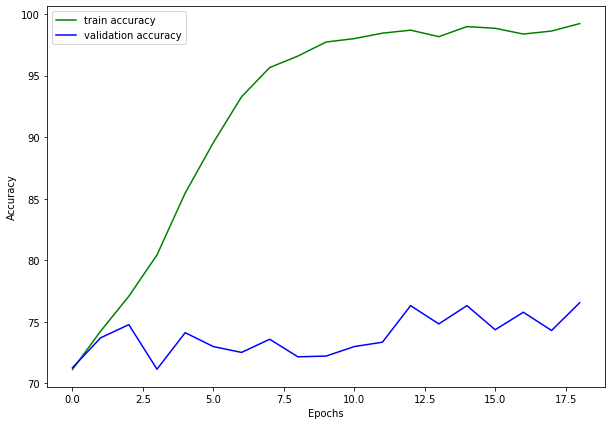

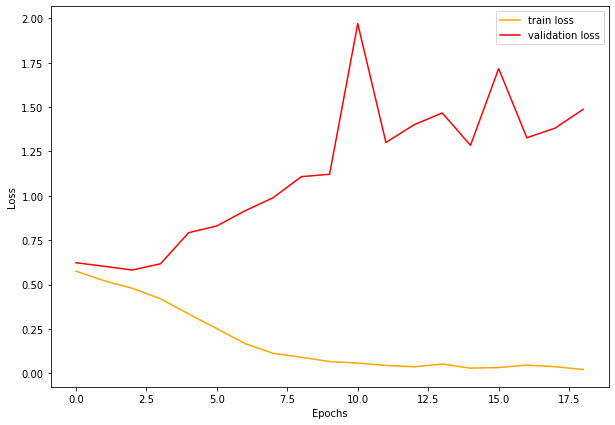

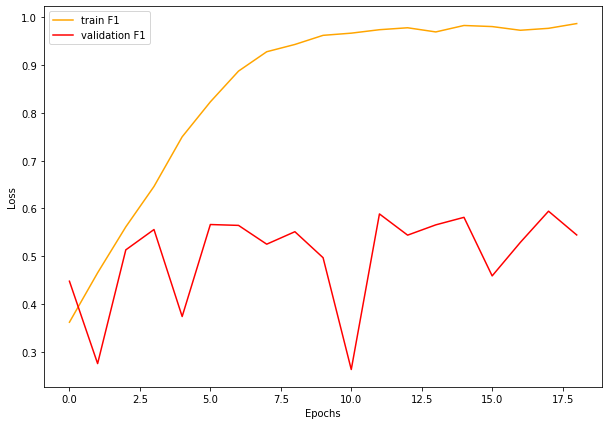

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss.png')
plt.show()

In [ ]:
blind_test_data = pano_images(xtest, ytest, tfms=0)
blindtestloader = DataLoader(blind_test_data, batch_size=200, shuffle=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet_mask_multiplied_output/epoch17"))
validate(model, testloader)




  0%|          | 0/8 [00:00<?, ?it/s]

Validating





 12%|█▎        | 1/8 [00:02<00:14,  2.13s/it]


 25%|██▌       | 2/8 [00:04<00:12,  2.13s/it]


 38%|███▊      | 3/8 [00:06<00:10,  2.12s/it]


 50%|█████     | 4/8 [00:08<00:08,  2.11s/it]


 62%|██████▎   | 5/8 [00:10<00:06,  2.11s/it]


 75%|███████▌  | 6/8 [00:12<00:04,  2.10s/it]


 88%|████████▊ | 7/8 [00:14<00:02,  2.10s/it]


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


9it [00:17,  1.97s/it]

Val Loss: 1.3808, Val Acc: 74.29
Recall: 0.6228, Precision: 0.57, F1: 0.59
TP 317 TN 934 FP 241 FN 192


(1.3808464258909225, 74.2874109263658, 0.5941893158388004)